# Анализ пользователей сервиса "Ненужные вещи"

Сервис "Ненужные вещи" предоставляет пользователям возможность продать свои ненужные вещи другим людям. Ближайший аналог - сервис "Авито".

**Цель работы**: выделить (сегментировать) пользователей на группы на основе их поведения для лучшей адаптации приложения.

Описание данных:

Датасет содержит данные о событиях, совершенных в мобильном приложении
"Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая
их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в
приложении после 7 октября 2019 года.

Колонки в `/datasets/mobile_sources.csv`:

`userId` — идентификатор пользователя,

`source` — источник, с которого пользователь установил приложение.

Колонки в `/datasets/mobile_dataset.csv`:

`event.time` — время совершения,

`user.id` — идентификатор пользователя,

`event.name` — действие пользователя.

Виды действий:

`advert_open` — открыл карточки объявления,

`photos_show` — просмотрел фотографий в объявлении,

`tips_show` — увидел рекомендованные объявления,

`tips_click` — кликнул по рекомендованному объявлению,

`contacts_show` и `show_contacts` — посмотрел номер телефона,

`contacts_call` — позвонил по номеру из объявления,

`map` — открыл карту объявлений,

`search_1` — `search_7` — разные действия, связанные с поиском по сайту,

`favorites_add` — добавил объявление в избранное.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from datetime import datetime, timedelta
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots


%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('figure', figsize=(15, 6))

## Загрузка датасетов

In [16]:
URL_dataset = 'https://code.s3.yandex.net/datasets/mobile_dataset.csv'
URL_source = 'https://code.s3.yandex.net/datasets/mobile_sources.csv'

dataset = pd.read_csv(URL_dataset)
source = pd.read_csv(URL_source)

# Предобработка данных

### Изучение общей информации

In [17]:
# смотрим на случайные данные из таблицы
display(dataset.sample(5))

# выводим общую информацию о датасете
dataset.info()

,event.time,event.name,user.id
39718,2019-10-22 23:23:42.388647,search_2,3bf4cc5d-9c65-42a1-8423-e2ae94dec3c5
62640,2019-10-30 15:55:16.793274,tips_show,82b34d46-a358-419d-aaad-6d887afcb6fd
30231,2019-10-19 11:51:35.621453,tips_show,2bdd8bdb-60c2-4c32-b26d-fef70b67c2a7
54075,2019-10-27 19:59:51.218253,photos_show,13140930-df18-4793-a230-7cca5c8813db
13330,2019-10-13 01:59:27.477530,tips_show,e6f8746e-c84c-4c8b-8f51-69518d640a43


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


В датасете три колонки с названиями `event.time`, `event.name`,	`user.id`. Названия не соответствуют `snake_case` - надо изменить.

Всего в датасете 74197 строк.

По таблице с информацией видно, что колонка с данными о времени имеет тип object, что затруднит работу с датой. Изменим на формат `datetime`.

Пропусков в таблице нет.

In [18]:
#переводим даты в формат datetime
dataset['event.time'] = pd.to_datetime(dataset['event.time'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event.time  74197 non-null  datetime64[ns]
 1   event.name  74197 non-null  object        
 2   user.id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


Колонку `event.time` привели к в формату datetime

In [19]:
# смотрим на случайные данные из таблицы c источниками
display(source.sample(5))

# выводим общую информацию о source
source.info()

,userId,source
2218,55540c74-5f58-4a4f-997a-e1cb2add2e59,google
3346,83134124-647a-40f9-8c86-5231f0ae0da6,google
1927,f3f3559d-4f95-4028-bdf9-4668d198af6b,other
1327,6e2e2141-a60d-4b53-a7f1-c7267c13963e,yandex
941,8ca6b3b3-0237-4aba-bb1d-bdcb67133524,google


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


Надо изменить имя колонки с id пользователей, иначе не получится их объединить. Таблица с информацией говорит, что пропусков также нет.

### Проверка на дубликаты

In [20]:
# проверим на дудликаты dataset
dataset.duplicated().sum()

np.int64(0)

In [21]:
# проверим на дудликаты source
source.duplicated().sum()

np.int64(0)

Дубликатов нет

### Проверка на наличие пропущенных значений

Проверку мы уже провели на стадии просмотра общей информации, но можно удостовериться еще раз.

In [22]:
# смотрим на долю пропусков в dataset
dataset.isna().mean()

,0
event.time,0.0
event.name,0.0
user.id,0.0


In [23]:
# смотрим на долю пропусков в dataset
source.isna().mean()

,0
userId,0.0
source,0.0


Пропусков нет

### Приведение названий столбцов к общепринятому стилю

In [24]:
# изменим имя колонок в датасете
dataset = dataset.rename(columns={'event.time': 'event_time', 'event.name': 'event_name', 'user.id': 'user_id'})
# изменим имя колонок в source
source = source.rename(columns={'userId': 'user_id'})

Имена колонок изменили.

### Объединение датафреймов

In [25]:
# проверим, что количество уникальных пользователей в двух таблицах одинаково
dataset['user_id'].nunique() == source['user_id'].nunique()

True

In [26]:
# объединим датасеты
df = pd.merge(dataset, source, how='left', on='user_id')
df

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
...,...,...,...,...
74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google
74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google
74194,2019-11-03 23:56:57.041825,search_1,20850c8f-4135-4059-b13b-198d3ac59902,google
74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google


In [27]:
# проверим, что после слияние количество уникальных пользователей не изменилось
df['user_id'].nunique() == dataset['user_id'].nunique()

True

Датасеты объединили. Количество строк и уникальных пользователей не изменилось.

#### Объединение значений `contacts_show` и `show_contacts`.

Значения `contacts_show` и `show_contacts` это одно и тоже. Различия могли возникнуть при выгрузке - вероятно человеческий фактор.
Также считаю, что можно объединить значения `search_1 — search_7` так как это повторяющиеся действия поиска.

In [28]:
# переименование событий show_contacts в contacts_show
df.loc[df['event_name'] == 'show_contacts', 'event_name'] = 'contacts_show'

# переименование действий search_1 - search_7 в search
df.loc[df['event_name'].str.startswith('search_'), 'event_name'] = 'search'

df['event_name'].value_counts()

,count
event_name,
tips_show,40055
photos_show,10012
search,6784
advert_open,6164
contacts_show,4529
map,3881
favorites_add,1417
tips_click,814
contacts_call,541


Значения `show_contacts` и `search_1 — search_7` объединены успешно.

### Добавление новых столбцов

#### Выделение в отдельный столбец данных о сессиях.

Новая сессия будет начинаться после 15-минутного простоя. Данное время было выбрано так как длительные сессии потребляют серверные ресурсы (память, CPU). Таймаут в 15 минут освобождает ресурсы для активных пользователей, улучшая производительность системы. Также согласное статье Vora, P. (2009). User Authentication. Web Application Design Patterns, 49–77. doi:10.1016/b978-0-12-374265-0.00003-7 типичное время сессии составляет 15-45 минут.

In [29]:
# Сортировка
df = df.sort_values(['user_id', 'event_time'])

# Перевод времени в секунды
diff_timestamp = df.groupby('user_id')['event_time'].diff().dt.total_seconds()

# индексы, в которых будут создаваться новые session_id
# 1 сессия - длительность менее 15 минут (900 сек)
new_session = (diff_timestamp.isnull()) | (diff_timestamp > 900)

# Создание сессий для каждого пользователя
df['session_id'] = (df.loc[new_session, ['user_id', 'event_time']]
                    .groupby('user_id')
                    .rank(method='first')
                    .astype(int))

# Убираем NaN и приводим к int
df['session_id'] = df['session_id'].fillna(method='ffill').astype(int)

df.head()

/tmp/ipython-input-29-1907418659.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['session_id'] = df['session_id'].fillna(method='ffill').astype(int)


,event_time,event_name,user_id,source,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1


In [30]:
# создание колонки session_start со временем начала всех сессий
df['session_start'] = df.groupby(['user_id', 'session_id'])['event_time'].transform('first')
# создание колонки session_start со временем конца всех сессий
df['session_end'] = df.groupby(['user_id', 'session_id'])['event_time'].transform('last')

#### Подготовка к анализу удержания пользователей.

Напишем функции для определения retention rate.

In [31]:
# Определим функцию, отвечающую за получение профилей пользователей

def get_profiles(data):
    '''
    Функция для создания профилей пользователей
    На вход получает датафрейм
    На выход - профили пользователей
    '''

    profiles = (
        data.sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg({'event_time': 'first', 'source': 'first'})
        .rename(columns={'event_time': 'first_ts'})
        .reset_index()
    )

    # определяем дату первого посещения
    profiles['dt'] = profiles['first_ts'].dt.date


    return profiles

In [32]:
# запускаем функцию
profiles = get_profiles(df)
profiles

,user_id,first_ts,source,dt
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,yandex,2019-10-19
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,yandex,2019-11-01
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,google,2019-10-18
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,yandex,2019-10-25
...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2019-10-13 16:11:27.414960,yandex,2019-10-13
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,2019-10-07 20:32:49.997044,yandex,2019-10-07
4290,ffcf50d9-293c-4254-8243-4890b030b238,2019-10-23 11:51:35.199237,google,2019-10-23
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,2019-10-21 16:39:33.867145,yandex,2019-10-21


In [33]:
# выделим начало сессий в отдельную переменную
sessions = df[['user_id', 'session_start']].drop_duplicates()
sessions

,user_id,session_start
805,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359
6541,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09 18:33:55.577963
36412,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21 19:52:30.778932
37556,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22 11:18:14.635436
31632,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769
...,...,...
70661,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02 18:17:41.386651
70771,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02 19:25:53.794029
72321,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03 14:32:55.956301
72487,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03 15:36:01.007440


In [34]:
# Функция для расчета retention rate
def get_retention(profiles, sessions, observation_date, horizon_days,
                  dimensions=['dt'], accept_horizon=True):
    '''
    Функция расчета коэффициента удержания.
    На вход подаются профили(profiles), данные о сессиях(sessions),
    дата наблюдения(observation_date), горизонт анализа(horizon_days),
    измерения(dimensions - можно группировать по разным признакам,
    по умолчанию - dt), учитываем горизонт или нет (по умолчанию - да)

    Возвращаем сырые данные(result_raw) и таблицу удержания(result_grouped)
    '''

    # Определяем последнюю подходящую дату для когорт
    last_suitable_acquisition_date = observation_date
    if accept_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)

    # Фильтруем профили по дате регистрации
    filtered_profiles = profiles.query('dt <= @last_suitable_acquisition_date')

    # Фильтруем сессии, оставляем только до observation_date
    filtered_sessions = sessions[sessions['session_start'] <= pd.to_datetime(observation_date)]

    # Объединяем профили с отфильтрованными сессиями
    result_raw = filtered_profiles.merge(filtered_sessions, on='user_id', how='left')

    # Вычисляем лайфтайм
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    # Cтроим таблицу удержания
    result_grouped = result_raw.pivot_table(
        index=dimensions,
        columns='lifetime',
        values='user_id',
        aggfunc='nunique')
    # вычисляем размеры когорт
    cohort_sizes = (result_raw
                    .groupby(dimensions)
                    .agg({'user_id': 'nunique'})
                    .rename(columns={'user_id': 'cohort_size'}))

    # делим данные таблицы удержания на размеры когорт (0) день
    # заполняем пропущенные значения 0
    result_grouped = (result_grouped
                  .div(result_grouped[0], axis=0)
                  .fillna(0))
    # добавляем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    return result_raw, result_grouped

*Вывод по разделу:*
- Всего в датасете 74197 строк.
- Дубликатов нет
- Пропусков нет
- Изменили названия колонок в соответствии со стилем `snake_case`.
- Объединили датафреймы с названием `dataset` и `source`
- Объединили значения `contacts_show` и `show_contacts` а также `search_1 — search_7`.
- Добавили новые колонки с сессиями и выделили отдельный датафрейм с началом сессий.
- Написали функции получения профилей пользователей и расчета удержания.

## Исследовательский анализ данных

### Исследовать поведение всех пользователей:

#### Расчет retention rate.

In [35]:
# посчитаем retention rate с помощью функции, что мы написали
# в качестве горизонта анализа возьмем 7 дней
# дата наблюдения - 2019-10-28
result_raw, result_grouped = get_retention(profiles, sessions, observation_date=datetime(2019, 10, 28).date(), horizon_days=7)

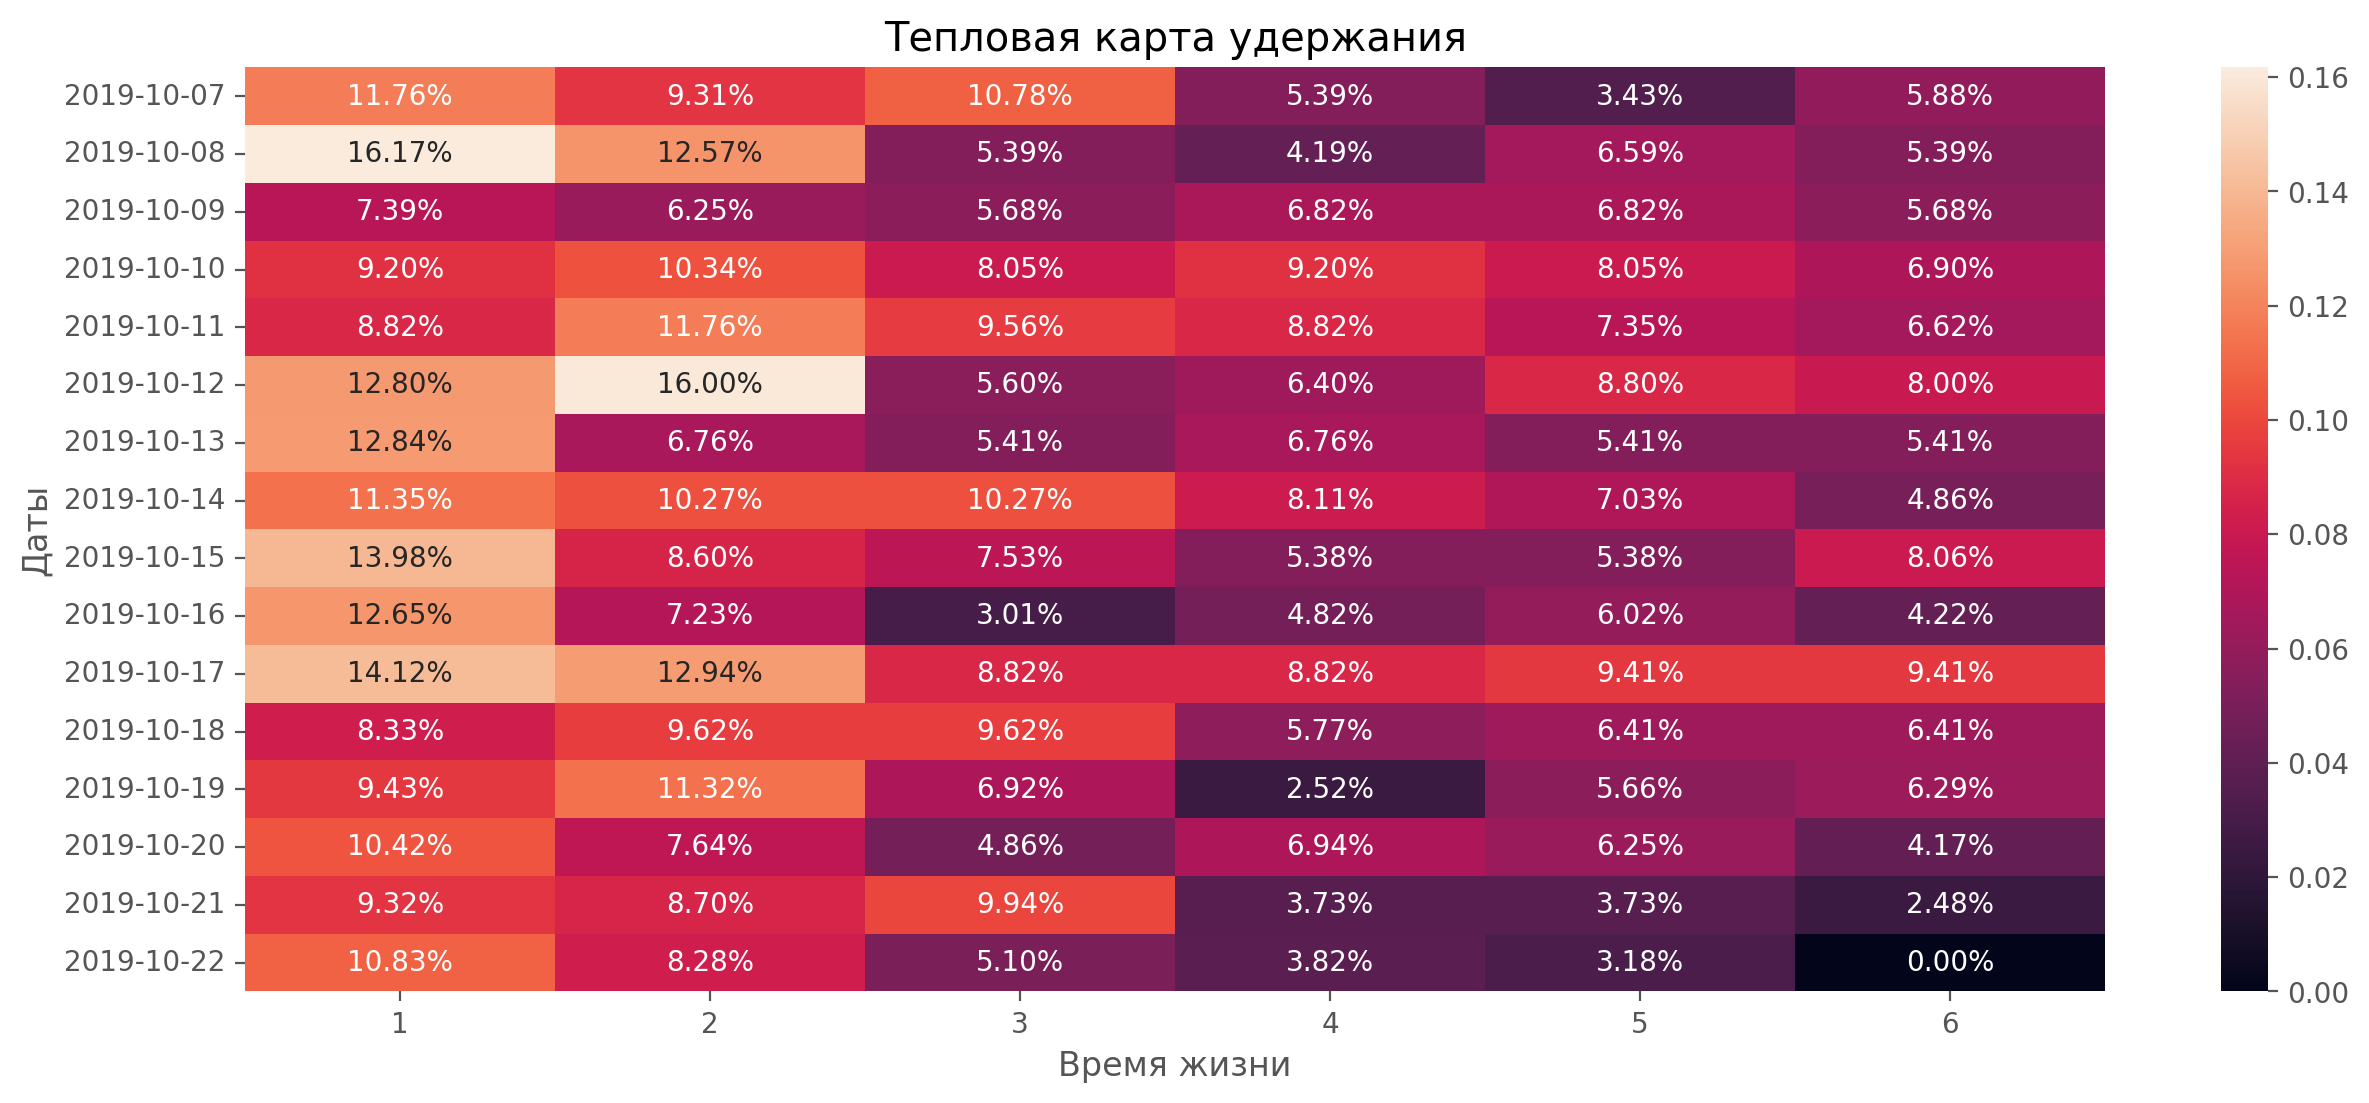

In [36]:
# строим хитмэп без нулевого лайфтайма и размера когорт
sns.heatmap(
    result_grouped.drop(columns=['cohort_size', 0]),
    annot=True,
    fmt='.2%',
)
plt.title('Тепловая карта удержания')
plt.xlabel('Время жизни')
plt.ylabel('Даты')
plt.show()

Расчет удержания показал, что на второй день после первого посещения в приложение заходят от 9% до 16%. Наилучшее удержание на второй день показали пользователи привлеченные 2019-10-08 - 16.17%, а наихудший - следующий день 2019-10-09. На последний день показатель удержания варьировался от 0 до 9.41%. В целом, все когорты идут ровно. Выделяются только пользователи, привлеченные 2019-10-17 - за весь горизонт наблюдения тут лучшие показатели по удержанию. Также довольно ровные показатели у пользователей от 2019-10-10 и 2019-10-11 - наблюдаются небольшие колебания удержания в районе 3% в обе стороны.
Худшие показатели демонстрируют пользователи от 2019-10-09 - удержание стабильно хуже, чем у остальных когорт. У когорты от 2019-10-22 в 7 день в приложение не зашел ни один человек, а также показатель удержания стабильно снижался с первого дня.

#### Расчет времени, проведённого в приложении.

In [37]:
# выделим пользователей в отдельную переменную с данными о сессиях
user_session_stats = df[['user_id', 'session_id', 'session_start', 'session_end']].drop_duplicates()
# посчитаем длительность каждой сессии
user_session_stats['session_duration'] = (user_session_stats['session_end'] - user_session_stats['session_start']).dt.seconds
user_session_stats.head()

,user_id,session_id,session_start,session_end,session_duration
805,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,595
6541,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,2019-10-09 18:33:55.577963,2019-10-09 18:42:22.963948,507
36412,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,2019-10-21 19:52:30.778932,2019-10-21 20:07:30.051028,899
37556,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,2019-10-22 11:18:14.635436,2019-10-22 11:30:52.807203,758
31632,00157779-810c-4498-9e05-a1e9e3cedf93,1,2019-10-19 21:34:33.849769,2019-10-19 21:59:54.637098,1520


In [38]:
# посчитаем средние значения длительности сессий всех пользователей
user_session_stats['session_duration'].describe()

,session_duration
count,11537.000000
mean,566.069255
std,851.108701
min,0.000000
25%,4.000000
50%,259.000000
75%,783.000000
max,14018.000000


Среднее значение 566 секунд, при стандартном отклонении в 841 сек, что говорит о большом разбросе данных. Медиана 259 секунд. 25% длительности сессий находится от 0 до 4 секунд - значит есть большое количество именно нулевых и около нулевых по длительности сессий.

In [39]:
# вычислим среднее значение, медиану длительности сессий уникальных пользователей
user_session_stats_grouped = (user_session_stats
                              .groupby('user_id')['session_duration']
                              .agg(['mean','median', 'count'])
                              .reset_index())

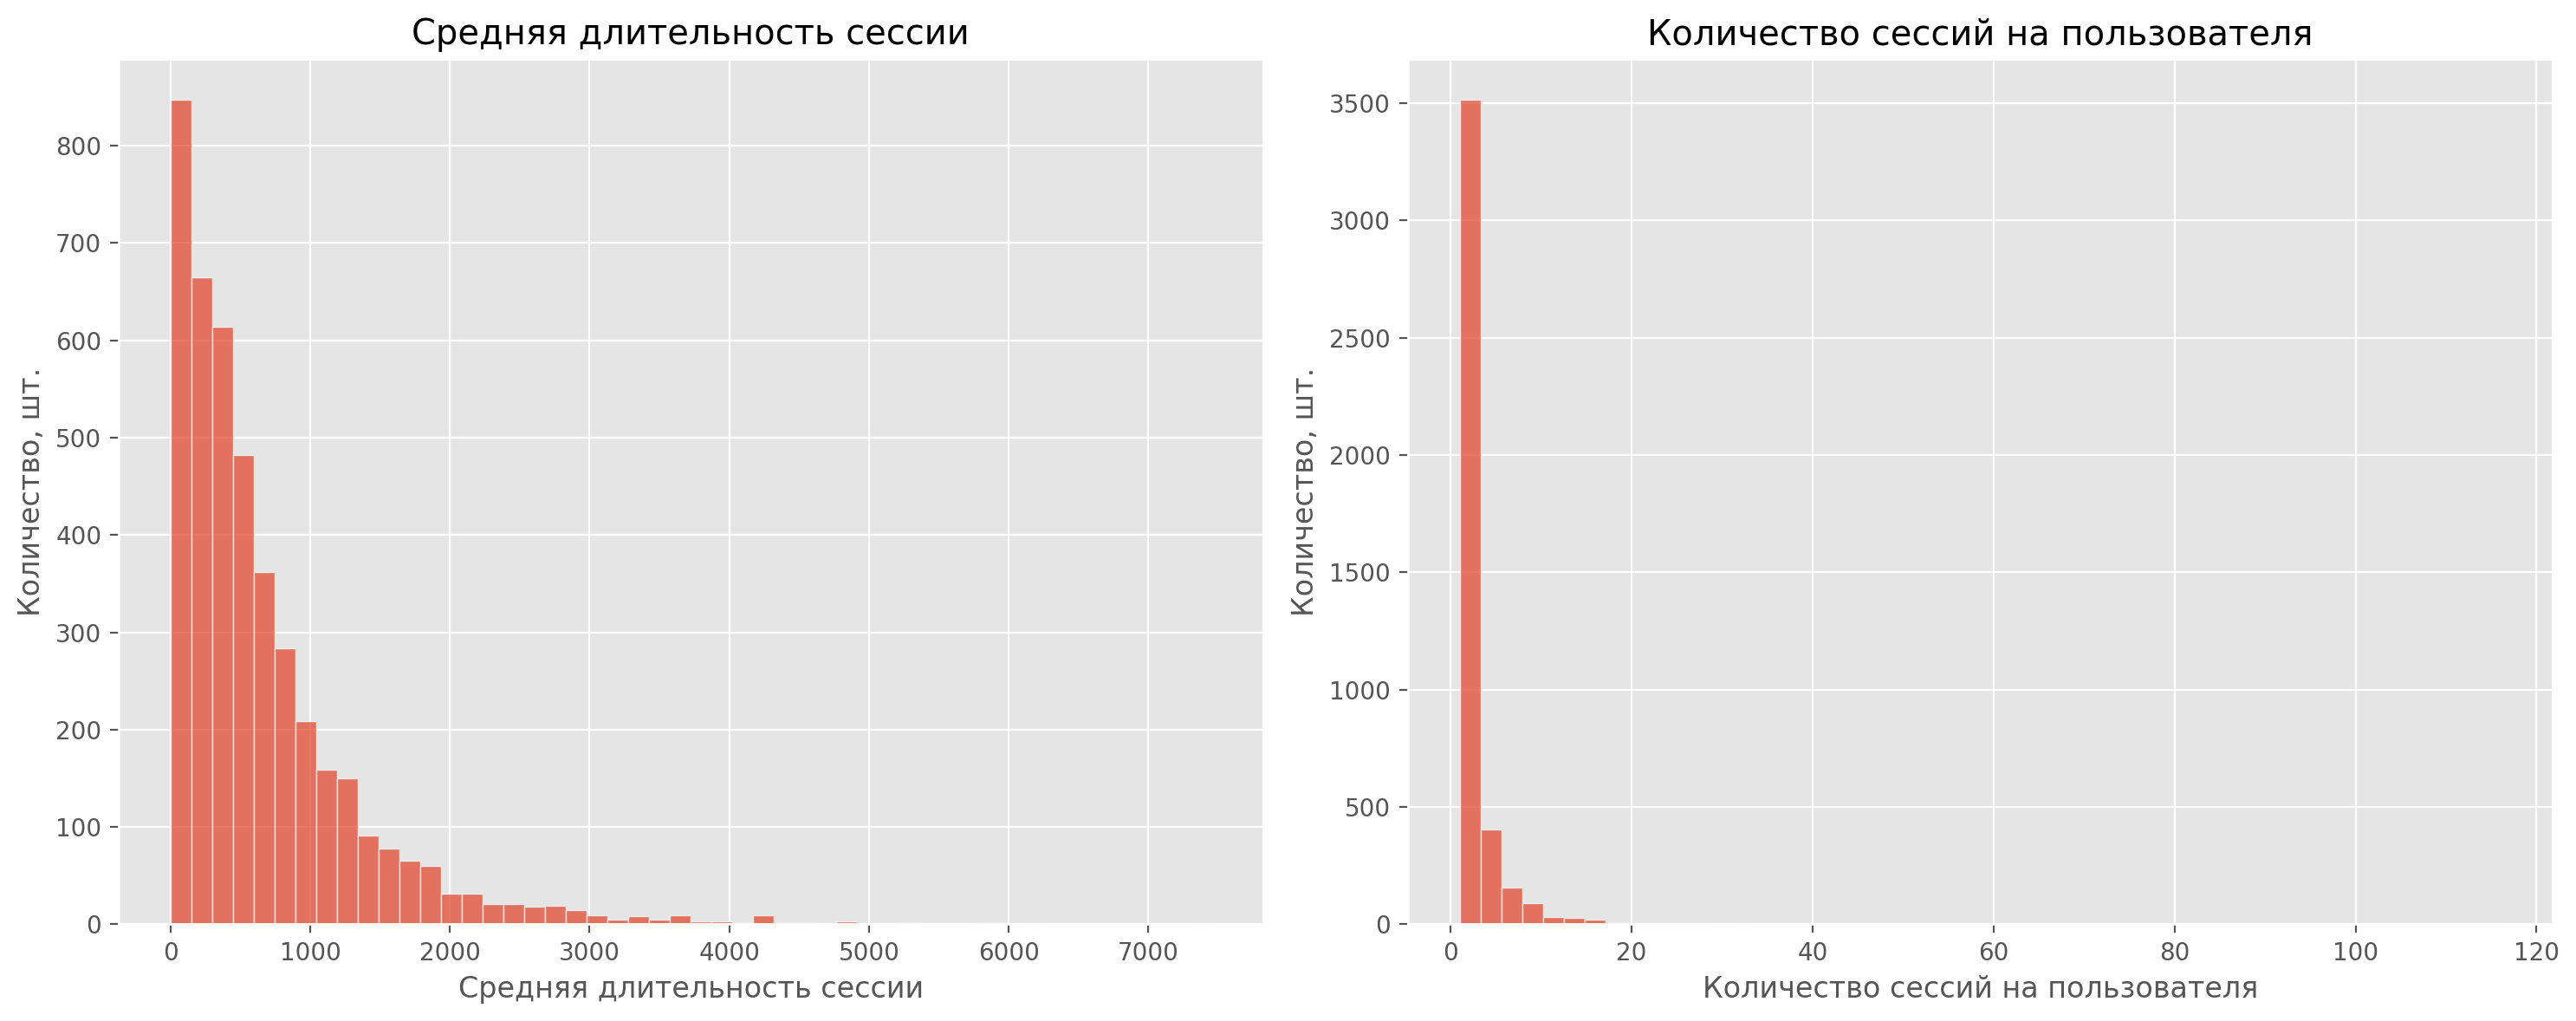

In [40]:
# Данные для графиков
labels = [('mean', 'Средняя длительность сессии'), ('count', 'Количество сессий на пользователя')]

# Создаем две области для графиков
fig, axes = plt.subplots(1, 2)

# Строим гистограммы в каждой области
for ax, (col, label) in zip(axes, labels):
    sns.histplot(data=user_session_stats_grouped[col], bins=50, ax=ax)
    ax.set_title(label)
    ax.set_xlabel(label)
    ax.set_ylabel('Количество, шт.')

plt.tight_layout()
plt.show()

Графики показывают:
1. Преобладают короткие сессии - наблюдается большое количество околонулевых по длительности сессий.
2. Есть отдельные длительные сессии - более 3000 секунд.
3. Подавляющее большинство пользователей имеют по 1 - 2 сессии. Но есть пользователи с 20 и более сессий.

То есть, много пользователей заходят по 1-2 раза на короткое время.

Посчитаем, много ли пользователей имеют 0-е по длительности сессии.

In [41]:
# сделаем запрос: среднее значение = 0
user_session_stats_grouped.query('mean == 0')

,user_id,mean,median,count
118,0729a0c7-9e58-4ea9-92bf-33830024ee68,0.0,0.0,1
124,07b1849e-eb60-444d-98cb-f8516ad23a74,0.0,0.0,1
202,0ba4e644-8d45-48b4-a8eb-98e5687ca092,0.0,0.0,1
212,0c63da08-3a7f-4e03-9deb-316e7b164ec1,0.0,0.0,3
242,0dea426d-4547-47d3-9ba2-716db6ca789b,0.0,0.0,1
...,...,...,...,...
3984,ed38683e-f887-429d-aa71-7fe8712ec22b,0.0,0.0,1
4073,f29d922b-fc75-4eeb-a584-0c3532aa03d1,0.0,0.0,1
4154,f81367bf-86de-4f2c-80d6-88871b7dccb8,0.0,0.0,1
4196,fa6aa4b5-d098-436d-9976-f87ed0cf1dca,0.0,0.0,1


Данные показывают, что 94 пользователя имеют длительность сессий равные 0. Посмотрим, какие действия были совершены за такую быструю сессию.

In [42]:
# выделим id пользователей
user_ids_zero_sessions = user_session_stats_grouped.query('mean == 0')['user_id']
user_ids_zero_sessions

,user_id
118,0729a0c7-9e58-4ea9-92bf-33830024ee68
124,07b1849e-eb60-444d-98cb-f8516ad23a74
202,0ba4e644-8d45-48b4-a8eb-98e5687ca092
212,0c63da08-3a7f-4e03-9deb-316e7b164ec1
242,0dea426d-4547-47d3-9ba2-716db6ca789b
...,...
3984,ed38683e-f887-429d-aa71-7fe8712ec22b
4073,f29d922b-fc75-4eeb-a584-0c3532aa03d1
4154,f81367bf-86de-4f2c-80d6-88871b7dccb8
4196,fa6aa4b5-d098-436d-9976-f87ed0cf1dca


In [43]:
# отфильтруем по id и посчитаем частоту появлений событий
df.query('user_id in @user_ids_zero_sessions')['event_name'].value_counts()

,count
event_name,
tips_show,65
photos_show,56
map,24
search,17
contacts_show,15
favorites_add,1
advert_open,1


В основном преобладают события - показа рекомендаций и просмотр фото. Рекомендации можно быстро убрать. Фото тоже можно быстро посмотреть, но тут также есть вероятность, что фото нет или оно не прогрузилось. На карту тоже возможно нажать случайно и сразу закрыть. В целом, 0-е по длительности действия выглядят не так будто это ошибка. За исключением показа фото. Возможно, есть ошибки на сервере.

In [44]:
# посмотрим на пользователей, чья длительность сессий больше 3000 секунд
with pd.option_context('display.max_rows', 100):
    display(user_session_stats_grouped.query('mean > 3000').sort_values(by='count', ascending=False))

,user_id,mean,median,count
3223,c140f88a-c544-4ce6-a6bd-578a1a0d1b18,6191.400000,5410.0,5
3724,dd61b125-4b5f-4312-82dc-dcc431980265,3021.200000,1332.0,5
70,04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791,4831.250000,5519.0,4
1935,74041397-d70d-49ab-8d8e-7f9d00f2ffea,4244.750000,5084.0,4
2790,a6bea8cc-9dfc-447b-ab9f-1e162ad2cb74,3269.333333,2600.0,3
3071,b814b321-58ca-4ab7-aaf6-fbe065343ea5,3580.333333,5048.0,3
2211,84557d6b-7887-4baf-9281-97c2e0f76e98,3078.666667,3505.0,3
925,3615463b-be22-4167-819c-324affd368a1,5290.666667,6282.0,3
3854,e549f8ef-653b-4c5c-a6bd-8970e6bd860b,3581.333333,813.0,3
2843,a975aed8-0663-4c61-8516-807b66f7e006,3024.500000,3024.5,2


У две трети из них по одной длинной сессии. Это выглядит странно. Возможно, что это ошибки при сборе данных.

Рассмотрим график количества сессий на пользователя получше - ограничем ось Х на 20 сессиях.

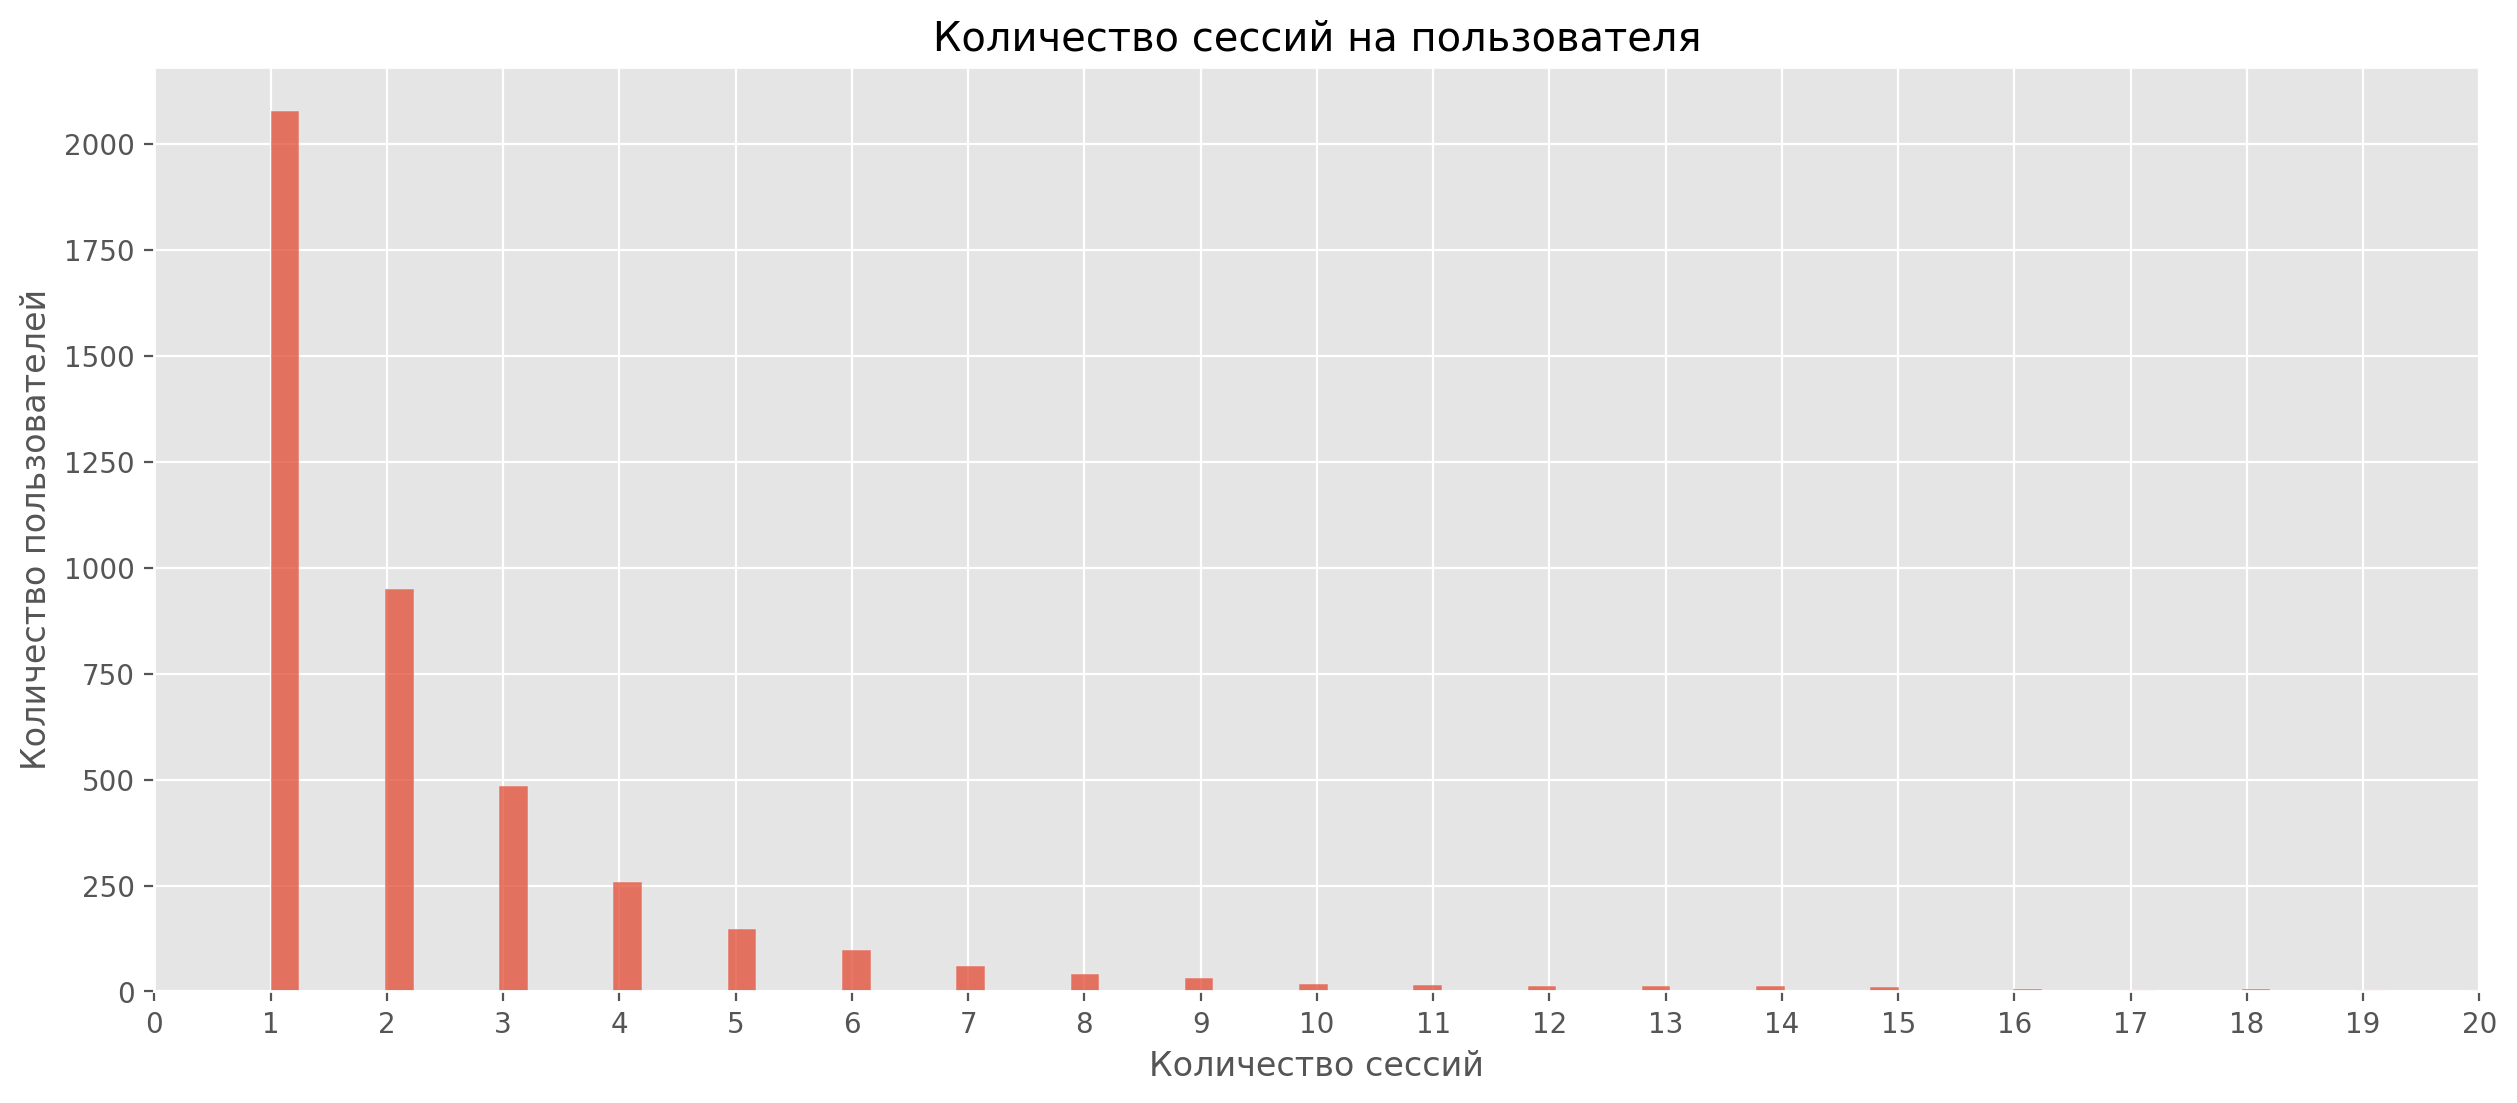

In [45]:
# строим график гистрограммы
fig, ax = plt.subplots()
sns.histplot(data=user_session_stats_grouped['count'], ax=ax)
ax.set_xlim(0, 20)
ax.set_xticks(np.arange(0, 21, 1))
ax.set_title('Количество сессий на пользователя')
ax.set_xlabel('Количество сессий')
ax.set_ylabel('Количество пользователей')
plt.show()

По увеличенному графику также видно, что большинство пользователей имеют только 1 сессию. В два раза меньше пользователей, которые заходили два раза. Также на графике есть длинный "хвост" тех, кто имеет множество сесссий.

Рассмотрим пользователей, что имели больше 10 сессий:

In [46]:
# посмотрим на пользователей, что имели больше 10 сессий
user_session_stats_grouped.query('count > 10').sort_values(by='count', ascending=False)

,user_id,mean,median,count
615,21230dd9-2f7f-4b77-a436-43d4d10388e0,339.318966,50.5,116
3397,cb36854f-570a-41f4-baa8-36680b396370,826.696203,445.0,79
401,1580911b-65db-4f1a-be7e-1ca39becac30,199.379310,9.5,58
3162,be1449f6-ca45-4f94-93a7-ea4b079b8f0f,791.781818,373.0,55
1668,6383ff6a-04b8-4562-a98f-bb4f760d3c39,178.869565,0.0,46
...,...,...,...,...
2633,9d29e775-c326-438e-a9ef-39883afd3442,1368.727273,1325.0,11
2942,af9485b4-7ed0-4041-bf4f-c52b38da35d8,323.000000,83.0,11
3367,c9b98940-25d4-436a-b768-6154d94fa40b,352.000000,214.0,11
3497,d1009241-cf6a-4730-8875-f5e703deb441,597.727273,462.0,11


Таких пользователей 126, причем у самое большое количество сессий - 116, с средним временем 339 секунд и медианой - 50 секунд. Такая разница говорит, что сессии были не сбалансированы по продолжительности. Похожие величины и у пользователей ниже по списку. Однако, есть сессии, у которых медиана 0, что может говорить о том, что это либо ошибка в подсчетах логов, либо пользователи совершали много коротких заходов в приложение (также это может говорить о проблемах с входом в приложение, но данных, чтобы проверить это - недостаточно).  

#### Расчет частоты действий.

In [47]:
# расчет частоты действий
event_count = df.groupby('user_id')['event_name'].count().reset_index()

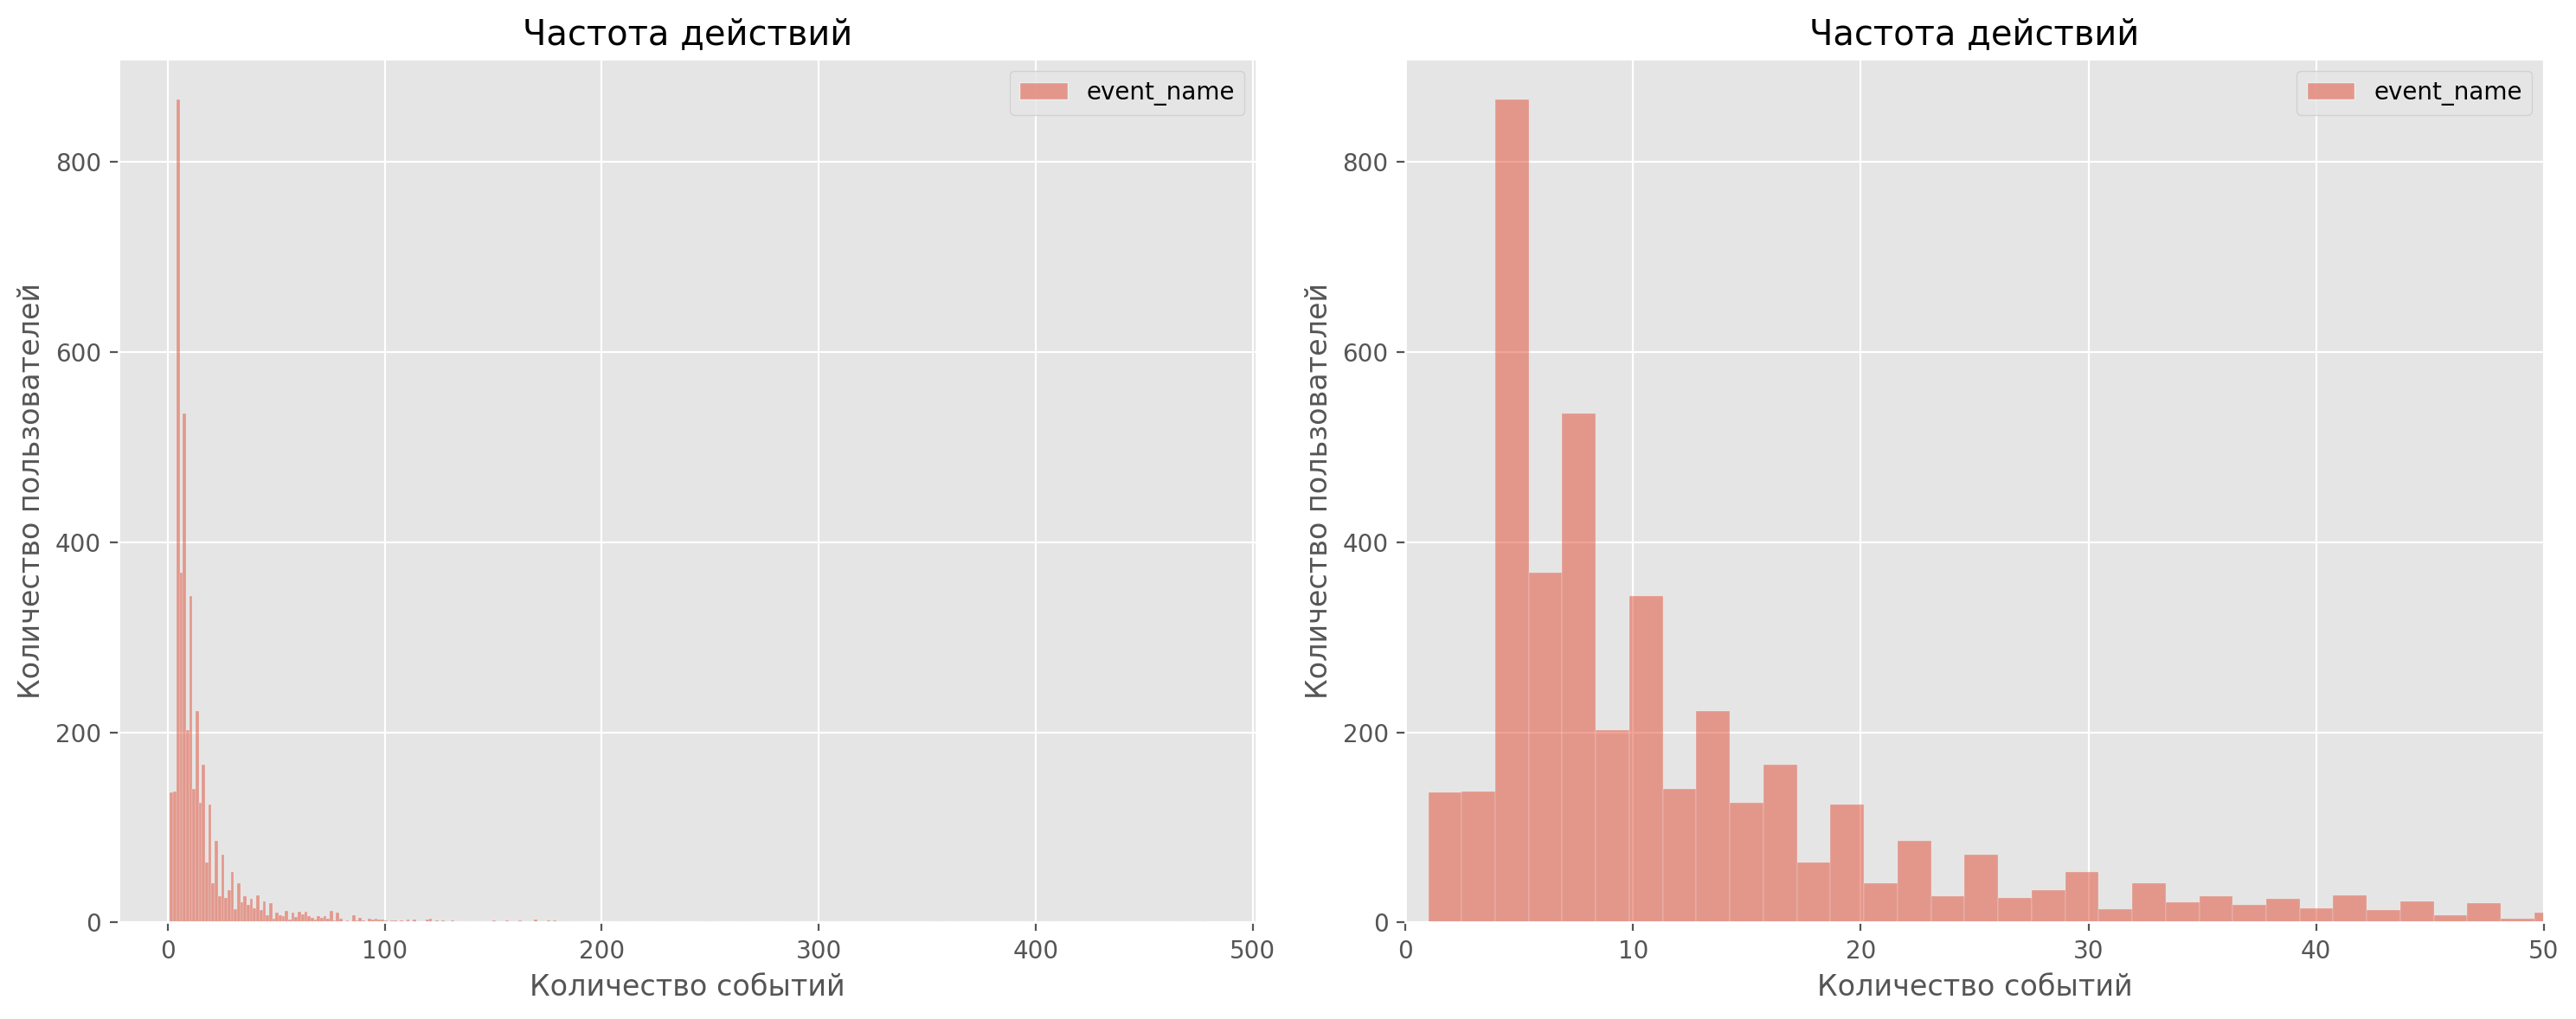

In [48]:
# строим график частоты действий
plt.subplot(1, 2, 1)
sns.histplot(data=event_count)
plt.title('Частота действий')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')

plt.subplot(1,2,2)
sns.histplot(data=event_count)
plt.xlim(0, 50)
plt.title('Частота действий')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')

plt.tight_layout()
plt.show()

Представлены два графика с частотами действий. Слева - без ограничения по оси Х, видно, что есть данные с очень большим количеством действий на пользователя. Возможно, что это не пользователь, а бот. Ограничение в по оси Х на 50 событий показывает, что в большинство пользователи совершают по 4-6 действий.

Подсчитаем тех, кто совершал более 50 действий:

In [49]:
tmp = event_count.sort_values(by='event_name', ascending=False)
tmp.query('event_name >=50')

,user_id,event_name
3397,cb36854f-570a-41f4-baa8-36680b396370,478
3794,e13f9f32-7ae3-4204-8d60-898db040bcfc,465
2629,9ce63488-758a-481a-bcb5-a02b467e1d84,407
615,21230dd9-2f7f-4b77-a436-43d4d10388e0,400
3162,be1449f6-ca45-4f94-93a7-ea4b079b8f0f,397
...,...,...
1114,40deaa4d-00e7-4297-9b3f-3b97a285c7bd,50
3857,e5773d92-9b5e-437d-bd47-c16ed5cb87b0,50
2954,b03f4137-440d-4f21-b656-7ed49a545ac0,50
2112,7ebd245c-798c-4070-8c47-297dc3d6c746,50


In [50]:
# посмотрим на пользователя с максимальным количеством действий
display(df.query('user_id == "cb36854f-570a-41f4-baa8-36680b396370"'))

,event_time,event_name,user_id,source,session_id,session_start,session_end
516,2019-10-07 11:39:42.961713,map,cb36854f-570a-41f4-baa8-36680b396370,yandex,1,2019-10-07 11:39:42.961713,2019-10-07 12:43:46.327683
518,2019-10-07 11:39:45.215686,map,cb36854f-570a-41f4-baa8-36680b396370,yandex,1,2019-10-07 11:39:42.961713,2019-10-07 12:43:46.327683
519,2019-10-07 11:39:46.305645,map,cb36854f-570a-41f4-baa8-36680b396370,yandex,1,2019-10-07 11:39:42.961713,2019-10-07 12:43:46.327683
520,2019-10-07 11:39:47.446962,map,cb36854f-570a-41f4-baa8-36680b396370,yandex,1,2019-10-07 11:39:42.961713,2019-10-07 12:43:46.327683
521,2019-10-07 11:39:48.652657,map,cb36854f-570a-41f4-baa8-36680b396370,yandex,1,2019-10-07 11:39:42.961713,2019-10-07 12:43:46.327683
...,...,...,...,...,...,...,...
67802,2019-11-01 13:25:04.375527,tips_show,cb36854f-570a-41f4-baa8-36680b396370,yandex,78,2019-11-01 13:16:05.574445,2019-11-01 13:25:04.375527
67954,2019-11-01 14:22:05.799550,tips_show,cb36854f-570a-41f4-baa8-36680b396370,yandex,79,2019-11-01 14:22:05.799550,2019-11-01 14:34:02.472249
67956,2019-11-01 14:22:19.254766,contacts_show,cb36854f-570a-41f4-baa8-36680b396370,yandex,79,2019-11-01 14:22:05.799550,2019-11-01 14:34:02.472249
67959,2019-11-01 14:24:03.664979,tips_show,cb36854f-570a-41f4-baa8-36680b396370,yandex,79,2019-11-01 14:22:05.799550,2019-11-01 14:34:02.472249


Таких пользователей довольно много - 266 человек.
Если смотреть на пользователя с максимальным количеством действий, то  видно, что это похоже на совершение действия пользователем (не ботом).

Рассмотрим динамику частоты действий пользоваталей - есть ли разница в активности пользователей в зависимости от дня недели.

In [51]:
# создадим копию датафрейма для работы с ней
events = df.copy()

In [52]:
# выделим дни недели из столбца event_time
events['day_of_week'] = events['event_time'].dt.day_name()
events.head()

,event_time,event_name,user_id,source,session_id,session_start,session_end,day_of_week
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,Monday
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,Monday
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,Monday
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,Monday
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,Monday


In [53]:
# группируем по дню недели, считаем события
day_distribution = events.groupby('day_of_week')['event_name'].agg('count').reset_index()
day_distribution = day_distribution.rename(columns={'event_name':'count'})
day_distribution

,day_of_week,count
0,Friday,9969
1,Monday,11671
2,Saturday,9154
3,Sunday,10501
4,Thursday,10762
5,Tuesday,11145
6,Wednesday,10995


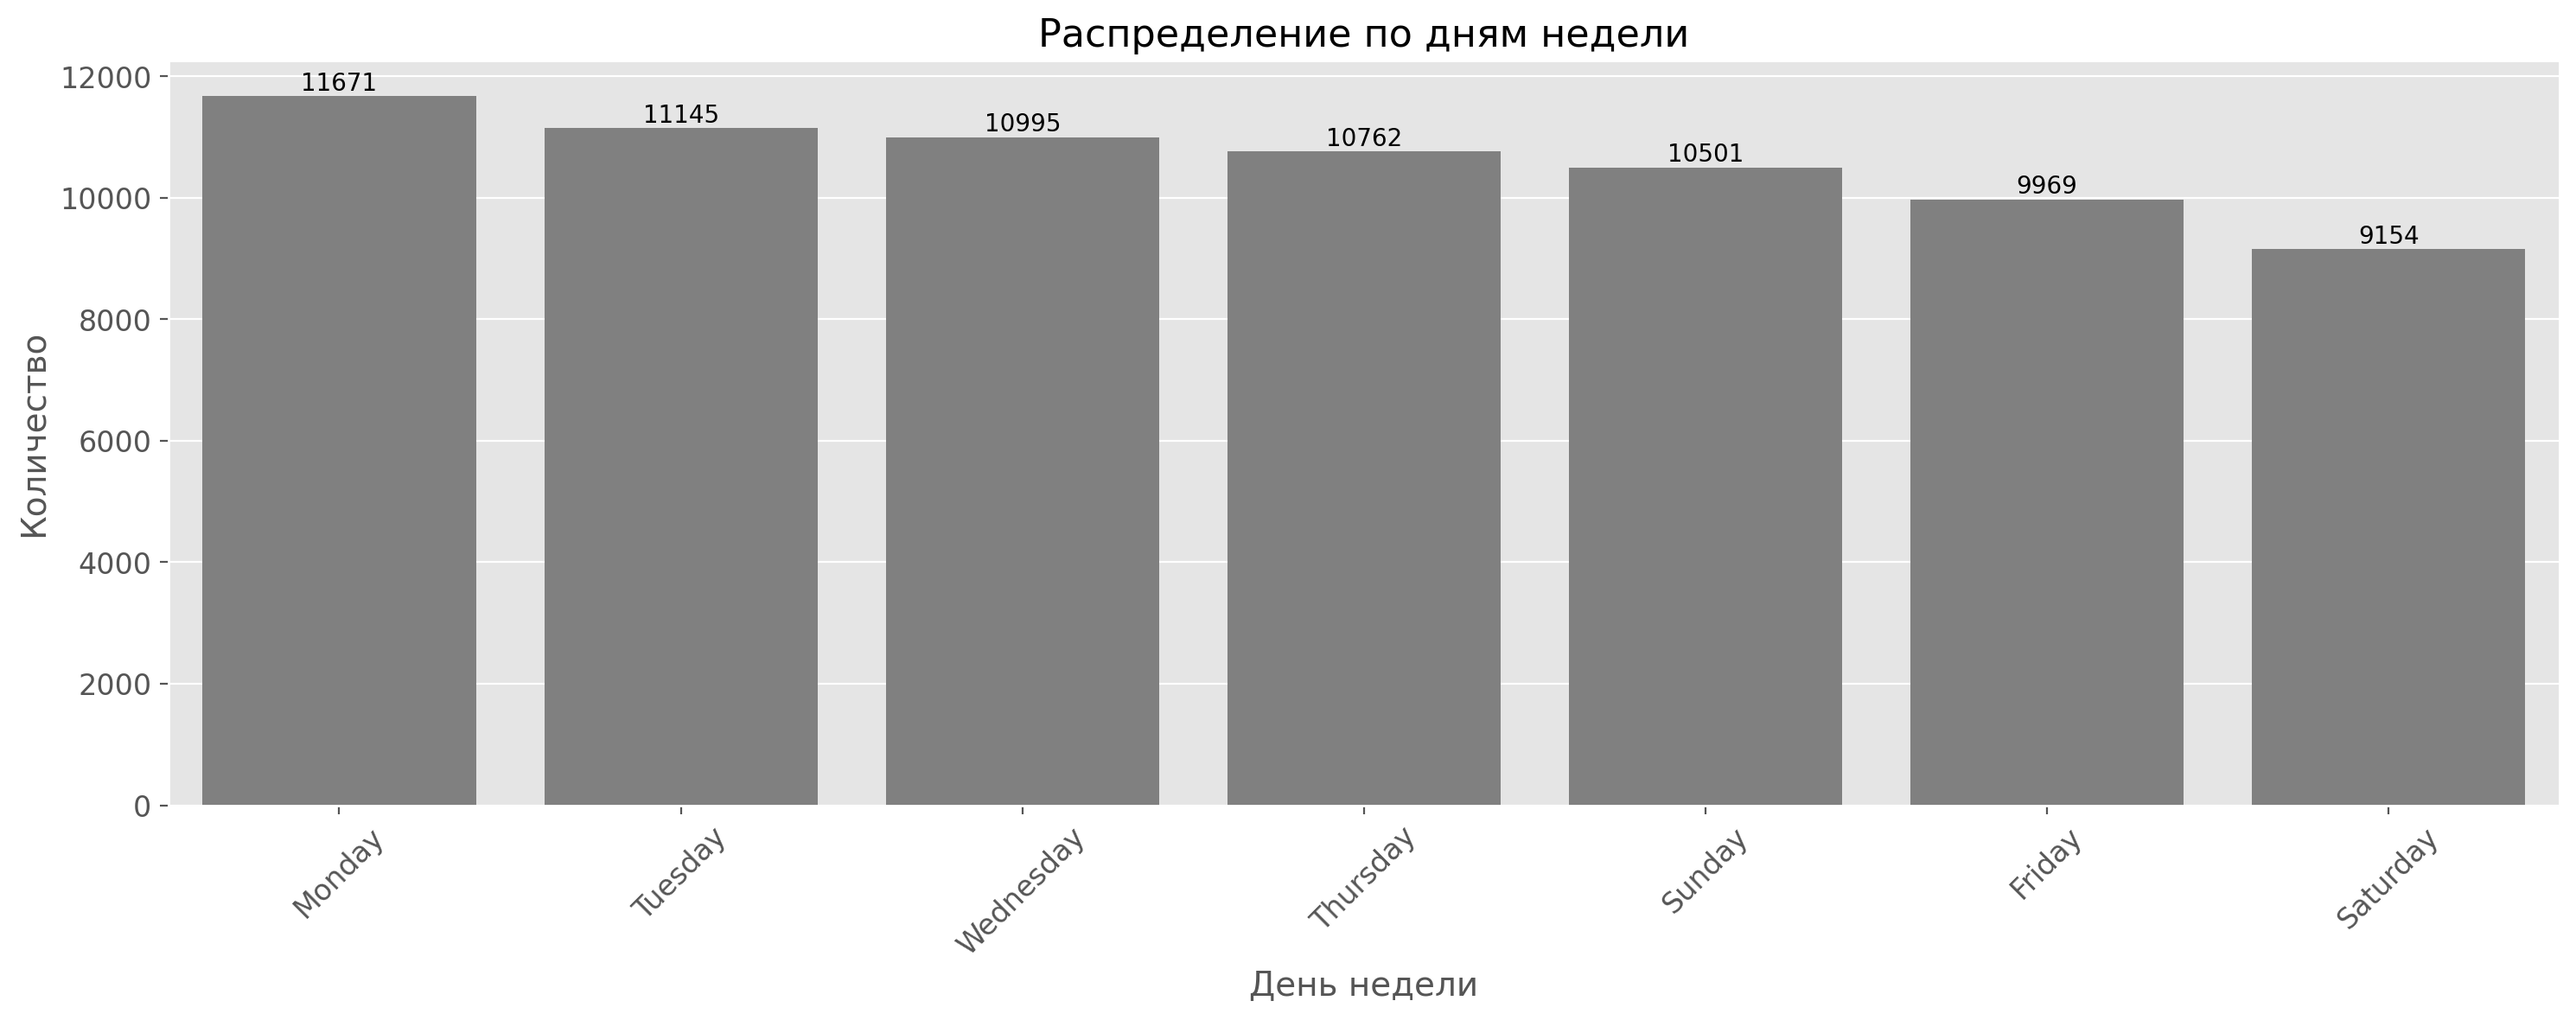

In [54]:
# строим график
sorted_data = day_distribution.sort_values(by='count', ascending=False)

ax = sns.barplot(
    data=sorted_data,
    x='day_of_week',
    y='count',
    color='gray'

)

plt.title('Распределение по дням недели', fontsize=16)
plt.xlabel('День недели', fontsize=14)
plt.ylabel('Количество', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

for index, value in enumerate(sorted_data['count']):
    plt.text(index, value + 100, str(value), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Наибольшая активность наблюдается в понедельник (11671 количество действий). Затем они плавно снижается к субботе, когда фиксируется минимальная активность (9154 действий). В воскресение активность снова вырастает почти до уровня четверга.

#### Подсчет конверсии в целевое действие — просмотр контактов.

Построим воронку действий.

In [55]:
# посчитаем количество совершенных действий пользователями
users_count = (df.groupby('event_name')
               .agg({'user_id': 'nunique'})
               .sort_values(by='user_id', ascending=False))
users_count

,user_id
event_name,
tips_show,2801
search,1666
map,1456
photos_show,1095
contacts_show,981
advert_open,751
favorites_add,351
tips_click,322
contacts_call,213


Видим, что есть большое количество действий поиска и показа рекомендаций.
Могу предложить два варианта воронок:
1. search -> advert_open -> photos_show -> contacts_show

То есть, сначала поиск, потом открытие карточки -> показ фото и конечное действие - показ контактов.

2. search -> tips_show -> tips_click -> photos_show -> contacts_show

Поиск - показ рекомендации - открытие рекомендации - пока фото и затем показ контактов.

In [56]:
# функция расчета значений воронки

def calculate_funnel(df, event_chain):
    """
    Рассчитывает воронку: количество уникальных пользователей, выполнивших цепочку событий.
    Принимает датафрейм (df) и
    event_chain (list): Список событий в порядке воронки.

    Возвращает список из количества пользователей на каждом шаге воронки.
    """
    # текущие пользователи
    current_users = None
    funnel_counts = []

    for event in event_chain:
        # Получаем всех пользователей, выполнивших текущее событие
        event_users = set(df[df['event_name'] == event]['user_id'].unique())

        # Если это первый шаг, сохраняем всех пользователей события
        if current_users is None:
            current_users = event_users
        else:
            # Пересечение с предыдущими пользователями
            current_users = current_users & event_users

        # Записываем количество пользователей на текущем шаге
        funnel_counts.append(len(current_users))

        # Если пользователей не осталось, прерываем цикл
        if not current_users:
            break

    # Заполняем оставшиеся шаги нулями (если воронка оборвалась)
    if len(funnel_counts) < len(event_chain):
        funnel_counts += [0] * (len(event_chain) - len(funnel_counts))

    return funnel_counts

In [57]:
def funnel_building(funnel_data, filtered_sessions, title=''):


    fig = make_subplots(
        rows=len(funnel_data)//2,
        cols=2,
        subplot_titles=[v['title'] for v in funnel_data.values()],
        vertical_spacing=0.15,
        horizontal_spacing=0.1
        )

    for i, (session_type, params) in enumerate(funnel_data.items()):
        row = (i // 2) + 1
        col = (i % 2) + 1


        if isinstance(filtered_sessions, dict):
            df = filtered_sessions[session_type]
        else:
            df = filtered_sessions
        values = calculate_funnel(df, params['stages'])


        fig.add_trace(
            go.Funnel(
                y=params['stages'],
                x=values,
                name=params['title'],
                marker={'color': params['color']},
                textinfo="value+percent initial",

                ),
            row=row,
            col=col
            )

    fig.update_layout(
        height=800,
        width=1300,
        showlegend=False,
        title_text=f"Воронка: {title}" if isinstance(filtered_sessions, dict) else 'Воронка действий',
        margin=dict(t=100)
        )


    for i in range(len(funnel_data)):
        fig.update_xaxes(row=(i//2)+1, col=(i%2)+1)
        fig.update_yaxes(row=(i//2)+1, col=(i%2)+1, title_text="Этапы")

    fig.show()


In [58]:
funnel_1  = ['search', 'advert_open', 'photos_show', 'contacts_show']
funnel_1_way = 'search -> advert_open -> photos_show -> contacts_show'
funnel_2 = ['search', 'tips_show', 'tips_click', 'photos_show', 'contacts_show']
funnel_2_way = 'search -> tips_show -> tips_click -> photos_show -> contacts_show'

funnels = [funnel_1, funnel_2]
funnels_way = [funnel_1_way, funnel_2_way]


funnel_data = {
        'funnel_1': {
            'title': funnel_1_way,
            'color': '#1f77b4',
            'stages': funnel_1
        },
        'funnel_2': {
            'title': funnel_2_way,
            'color': '#ff7f0e',
            'stages': funnel_2
        }}


funnel_building(funnel_data, filtered_sessions=df)


На выходе мы имеем две воронки:
- без учета просмотров рекомендаций. Здесь количество людей добравшиеся до целевого действия (`contacts_show`) составляет 1.5% от начального действия поиска.
- с учетом получения рекомендаций. Только 0.18% клиентов от начального прошли весь путь.

Таким образом, рекомендации, что посылают пользователям, снижают количество пользователей, прошедших весь путь от начальное действия. Зато на них откликаются - почти 50% получивших рекомендации перешли по ним.

In [78]:
# посчитаем общую конверсию
unique_users = df['user_id'].nunique()
unique_users_contacts_show = df.query('event_name == "contacts_show"')['user_id'].nunique()
conversion = unique_users_contacts_show / unique_users * 100

print(f'Конверсия в целевое действие равно: {conversion:.2f}%')

Конверсия в целевое действие равно: 22.85%


Общая конверсия равна 22.85%, что довольно много.

*Краткий вывод по разделу:*
1. Удержание:

На 2-й день удержание варьируется в диапазоне 9-16%. Лучший показатель у когорты 2019-10-08 (16.17%), худший — у 2019-10-09.

Когорта 2019-10-17 демонстрирует стабильно высокое удержание.

Пользователи 2019-10-09 и 2019-10-22 (нулевое удержание на 7-й день) требуют анализа причин низкой активности.

2. Длительность сессий:

25% сессий короче 4 секунд (много нулевых значений), что может указывать на ошибки логгирования или ботов (94 пользователя с нулевой длительностью).

Средняя длительность — 566 сек (медиана 259 сек) с сильным разбросом (от 0 до >3000 сек).

3. Активность пользователей:

Преобладают пользователи с 1-2 сессиями. Выявлены аномалии:

126 пользователей с >10 сессий (максимум — 116), где медиана длительности 50 сек при среднем 339 сек (неравномерное распределение).

266 пользователей совершили >50 действий (возможно боты или сверхактивные юзеры).

4. Воронки действий:

Конверсия в соответствии с воронкой в целевое действие (contacts_show) составляет 1.5% (без рекомендаций) и 0.18% (с рекомендациями).

Рекомендации не повышают итоговую конверсию, несмотря на 50% переходов по ним. Требуется оптимизация этапа после взаимодействия с рекомендациями.

Общая конверсия для всех пользователей составляет 22.85%.

### Исследовать поведение пользователей в зависимости от группы:

#### Сегментирование пользователей на основе данных о сессиях.

Было решено сегментировать пользователей по длительности сессий. Длительность сессий можно использовать для расчета метрик, таких как retention rate или конверсия в целевое действие. Например, предполагается, что пользователи с длительными сессиями будут иметь больший коэффициент удержания, совершать больше действий, что приведет к повышению конверсии. Также, в зависимости от длительности можно подключать дополнительную монетизацию или предлагать персонализированные предложения для возврата в приложение. Также анализ длительности поможет в оптимизации нагрузки на сервера или перераспределение ресурсов.

Сегментировать пользователей по длительности сессий можно путем разбиения продолжительности сессий по квартилям.

In [59]:
# посмотрим на данные со статистикой сессий
user_session_stats_grouped

,user_id,mean,median,count
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,689.750000,676.5,4
1,00157779-810c-4498-9e05-a1e9e3cedf93,851.888889,695.0,9
2,00463033-5717-4bf1-91b4-09183923b9df,1482.000000,1482.0,1
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,319.888889,279.0,9
4,00551e79-152e-4441-9cf7-565d7eb04090,186.333333,3.0,3
...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,1482.500000,1482.5,2
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,52.000000,52.0,1
4290,ffcf50d9-293c-4254-8243-4890b030b238,80.000000,80.0,1
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,777.000000,755.0,3


In [60]:
# добавим колонку с разбиением длительности сессий по квартилям
user_session_stats_grouped['duration_quartile'] = pd.qcut(user_session_stats_grouped['mean'], q=4)

# выведем получившиеся квартили и посчитаем количество пользователей в них
user_session_stats_grouped['duration_quartile'].value_counts()

,count
duration_quartile,
"(-0.001, 194.0]",1077
"(868.545, 7450.0]",1073
"(194.0, 453.0]",1072
"(453.0, 868.545]",1071


Мы разделили пользователей на 4 равные части. Можно переименовать каждые диапазоны квартилей. Назовем их "Кратковременные сессии (до 3 минут)", "Короткие сессии (3 - 8 минуты)", "Стандартные сессии (9 - 15 минут)" и "Длительные сессии (15 минут - 2 часа)".
Видно, что последняя группа - имеет сессии до 2 часов. Возможно, что это пользователи, которые очень пристрастно выбирают товары, но также есть вероятность, что это какая-то ошибка сборе логов.
Также, есть пользователи, у которых сессия длится 0 секунд. Возможно, что это боты или тоже сбой в сборе данных.

In [61]:
# изменим названия квартилей в датафрейме

new_labels = (["Кратковременные сессии (до 3 минут)",
              "Короткие сессии (3 - 8 минуты)",
               "Стандартные сессии (9 - 15 минут)",
               "Длительные сессии (15 минут - 2 часа)"])

user_session_stats_grouped["duration_quartile"] = (
    user_session_stats_grouped["duration_quartile"]
    .cat.rename_categories(new_labels))

user_session_stats_grouped

,user_id,mean,median,count,duration_quartile
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,689.750000,676.5,4,Стандартные сессии (9 - 15 минут)
1,00157779-810c-4498-9e05-a1e9e3cedf93,851.888889,695.0,9,Стандартные сессии (9 - 15 минут)
2,00463033-5717-4bf1-91b4-09183923b9df,1482.000000,1482.0,1,Длительные сессии (15 минут - 2 часа)
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,319.888889,279.0,9,Короткие сессии (3 - 8 минуты)
4,00551e79-152e-4441-9cf7-565d7eb04090,186.333333,3.0,3,Кратковременные сессии (до 3 минут)
...,...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,1482.500000,1482.5,2,Длительные сессии (15 минут - 2 часа)
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,52.000000,52.0,1,Кратковременные сессии (до 3 минут)
4290,ffcf50d9-293c-4254-8243-4890b030b238,80.000000,80.0,1,Кратковременные сессии (до 3 минут)
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,777.000000,755.0,3,Стандартные сессии (9 - 15 минут)


In [62]:
# добавим новую колонку с категорией по активности в profiles
profiles = pd.merge(profiles, user_session_stats_grouped[['user_id', 'duration_quartile']], on='user_id', how='left')
profiles

,user_id,first_ts,source,dt,duration_quartile
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07,Стандартные сессии (9 - 15 минут)
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,yandex,2019-10-19,Стандартные сессии (9 - 15 минут)
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,yandex,2019-11-01,Длительные сессии (15 минут - 2 часа)
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,google,2019-10-18,Короткие сессии (3 - 8 минуты)
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,yandex,2019-10-25,Кратковременные сессии (до 3 минут)
...,...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2019-10-13 16:11:27.414960,yandex,2019-10-13,Длительные сессии (15 минут - 2 часа)
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,2019-10-07 20:32:49.997044,yandex,2019-10-07,Кратковременные сессии (до 3 минут)
4290,ffcf50d9-293c-4254-8243-4890b030b238,2019-10-23 11:51:35.199237,google,2019-10-23,Кратковременные сессии (до 3 минут)
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,2019-10-21 16:39:33.867145,yandex,2019-10-21,Стандартные сессии (9 - 15 минут)


Пользователи разделены на 4 группы с названиями: "Кратковременные сессии (до 3 минут)", "Короткие сессии (3 - 8 минуты)", "Стандартные сессии (9 - 15 минут)" и "Длительные сессии (15 минут - 2 часа)". В каждой группе примерно равное количество пользователей - 1071-1077.

#### Расчет retention rate для каждой группы.

Посчитаем удержание (retention rate) для каждой группы.

In [63]:
# посчитаем retention rate с помощью функции, что мы написали ранее
# в качестве горизонта анализа возьмем 7 дней
# дата наблюдения - 2019-10-28
result_raw, result_grouped = get_retention(profiles,
                                           sessions,
                                           observation_date=datetime(2019, 10, 28).date(),
                                           horizon_days=7,
                                           dimensions=['duration_quartile', 'dt']
                                          )

result_grouped

/tmp/ipython-input-34-2037547630.py:31: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/tmp/ipython-input-34-2037547630.py:38: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



lifetime                                          cohort_size    0         1  \
duration_quartile                     dt                                       
Кратковременные сессии (до 3 минут)   2019-10-07           63  1.0  0.079365   
                                      2019-10-08           40  1.0  0.300000   
                                      2019-10-09           45  1.0  0.155556   
                                      2019-10-10           41  1.0  0.097561   
                                      2019-10-11           36  1.0  0.138889   
...                                                       ...  ...       ...   
Длительные сессии (15 минут - 2 часа) 2019-10-18           45  1.0  0.000000   
                                      2019-10-19           40  1.0  0.050000   
                                      2019-10-20           31  1.0  0.064516   
                                      2019-10-21           40  1.0  0.100000   
                                      2019-10-22           38  1.0  0.052632   

lifetime                                                 2         3  \
duration_quartile                     dt                               
Кратковременные сессии (до 3 минут)   2019-10-07  0.079365  0.158730   
                                      2019-10-08  0.175000  0.100000   
                                      2019-10-09  0.111111  0.133333   
                                      2019-10-10  0.024390  0.048780   
                                      2019-10-11  0.083333  0.111111   
...                                                    ...       ...   
Длительные сессии (15 минут - 2 часа) 2019-10-18  0.066667  0.066667   
                                      2019-10-19  0.075000  0.050000   
                                      2019-10-20  0.000000  0.032258   
                                      2019-10-21  0.050000  0.100000   
                                      2019-10-22  0.052632  0.078947   

lifetime                                                 4         5         6  
duration_quartile                     dt                                        
Кратковременные сессии (до 3 минут)   2019-10-07  0.047619  0.015873  0.031746  
                                      2019-10-08  0.075000  0.175000  0.150000  
                                      2019-10-09  0.133333  0.133333  0.066667  
                                      2019-10-10  0.024390  0.073171  0.024390  
                                      2019-10-11  0.111111  0.000000  0.055556  
...                                                    ...       ...       ...  
Длительные сессии (15 минут - 2 часа) 2019-10-18  0.088889  0.066667  0.088889  
                                      2019-10-19  0.000000  0.025000  0.000000  
                                      2019-10-20  0.064516  0.000000  0.000000  
                                      2019-10-21  0.025000  0.025000  0.025000  
                                      2019-10-22  0.000000  0.000000  0.000000  

[64 rows x 8 columns]

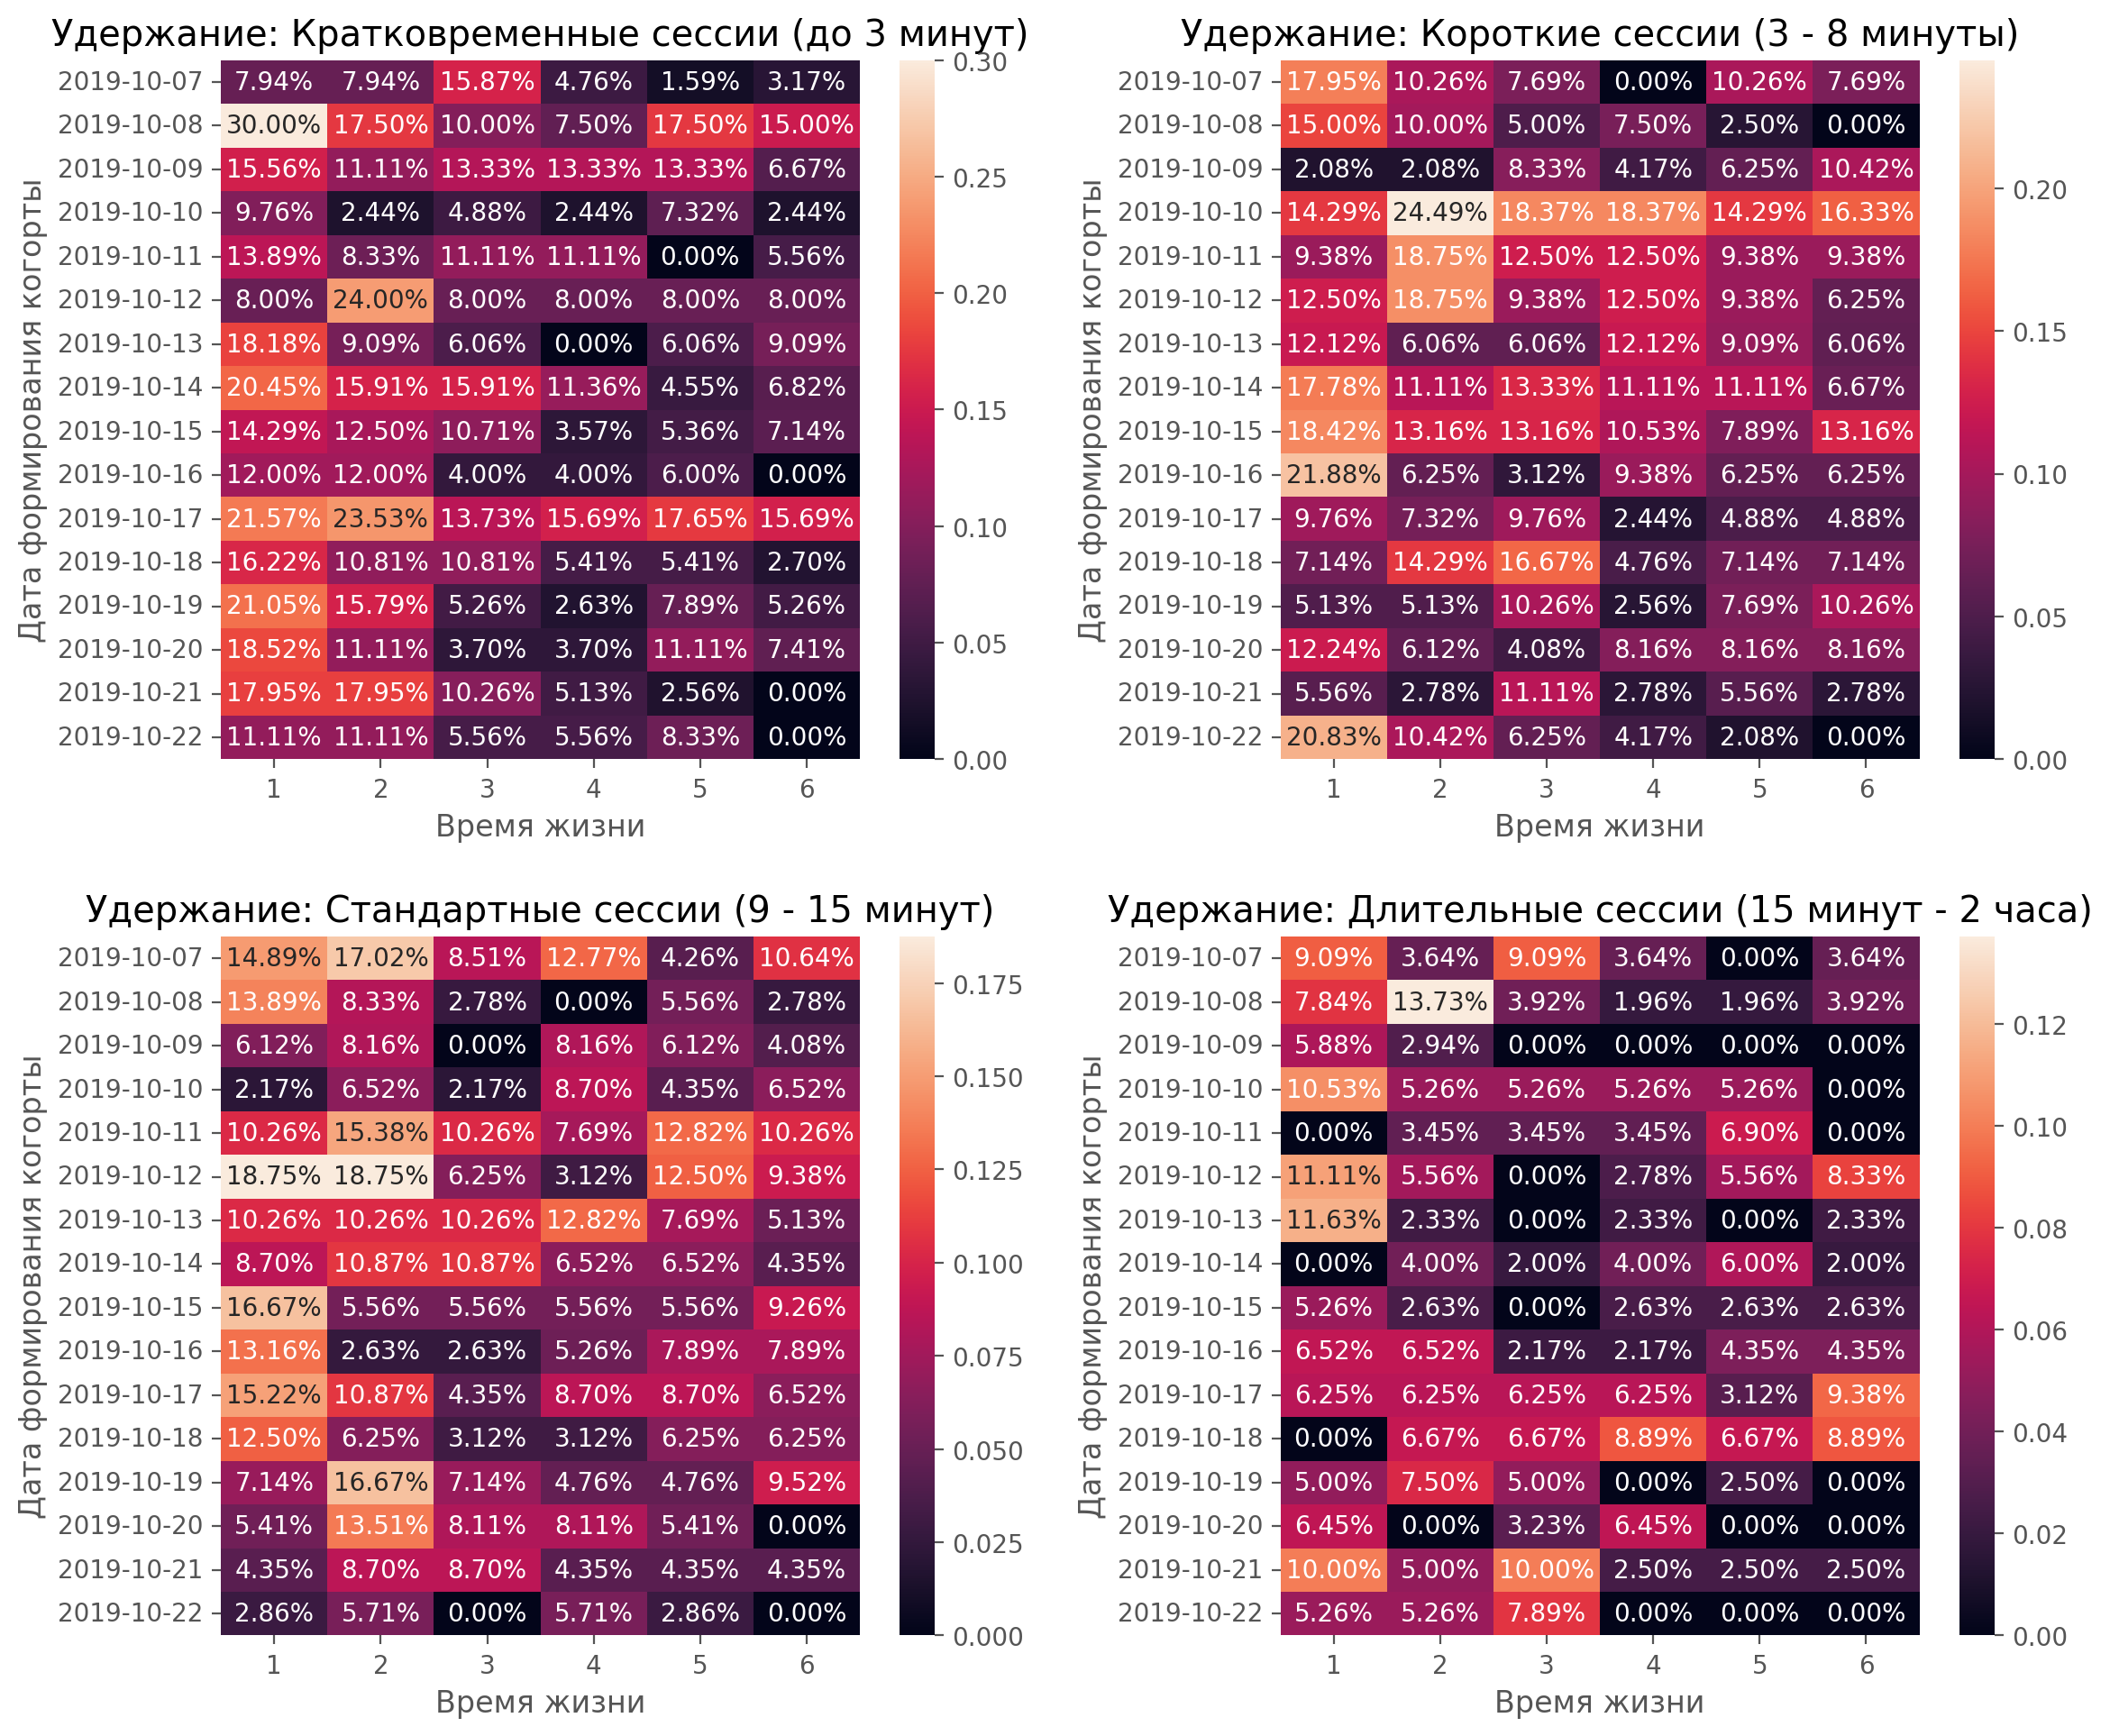

In [64]:
# построим heatmap для каждой группы
labels = (["Кратковременные сессии (до 3 минут)",
              "Короткие сессии (3 - 8 минуты)",
               "Стандартные сессии (9 - 15 минут)",
               "Длительные сессии (15 минут - 2 часа)"])

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flat

for ax, label in zip(axes, labels):
    data = (result_grouped.query(f'duration_quartile == "{label}"')
                         .drop(columns=['cohort_size', 0])
                         .reset_index(level='duration_quartile', drop=True))

    sns.heatmap(data=data,annot=True,fmt='.2%', ax=ax)

    ax.set_title(f'Удержание: {label}')
    ax.set_xlabel('Время жизни')
    ax.set_ylabel('Дата формирования когорты')


plt.tight_layout(pad=2.0)
plt.show()

Heatmap демонстрируют разнообразие удержаний в зависимости от групп. По интенсивности света можно сказать, что удержание группы "Длительные сессии" ниже остальных.

Явно выделяются значения удержания на первый день у всех групп - он достаточно высокий. Наибольший показатель - 30% характерен для пользователей группы "Кратковременные сессии" 2019-10-08 дня привлечения.

Наилучшие недели с самым высоким удержанием характерны для групп "Кратковременные сессии" - пользователи привлеченные 2019-10-17 (удержание падает с 21.57% до 15.69%) и группа "Короткие сессии" - пользователи привлеченные 2019-10-10 (удержание сначала растет с 14.29% до 24.49%, а потом падает до 16.33%)

Рассмотрим средние значения удержания пользователей за 7 дней в зависимости от длительности сессий.

/tmp/ipython-input-65-14573928.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



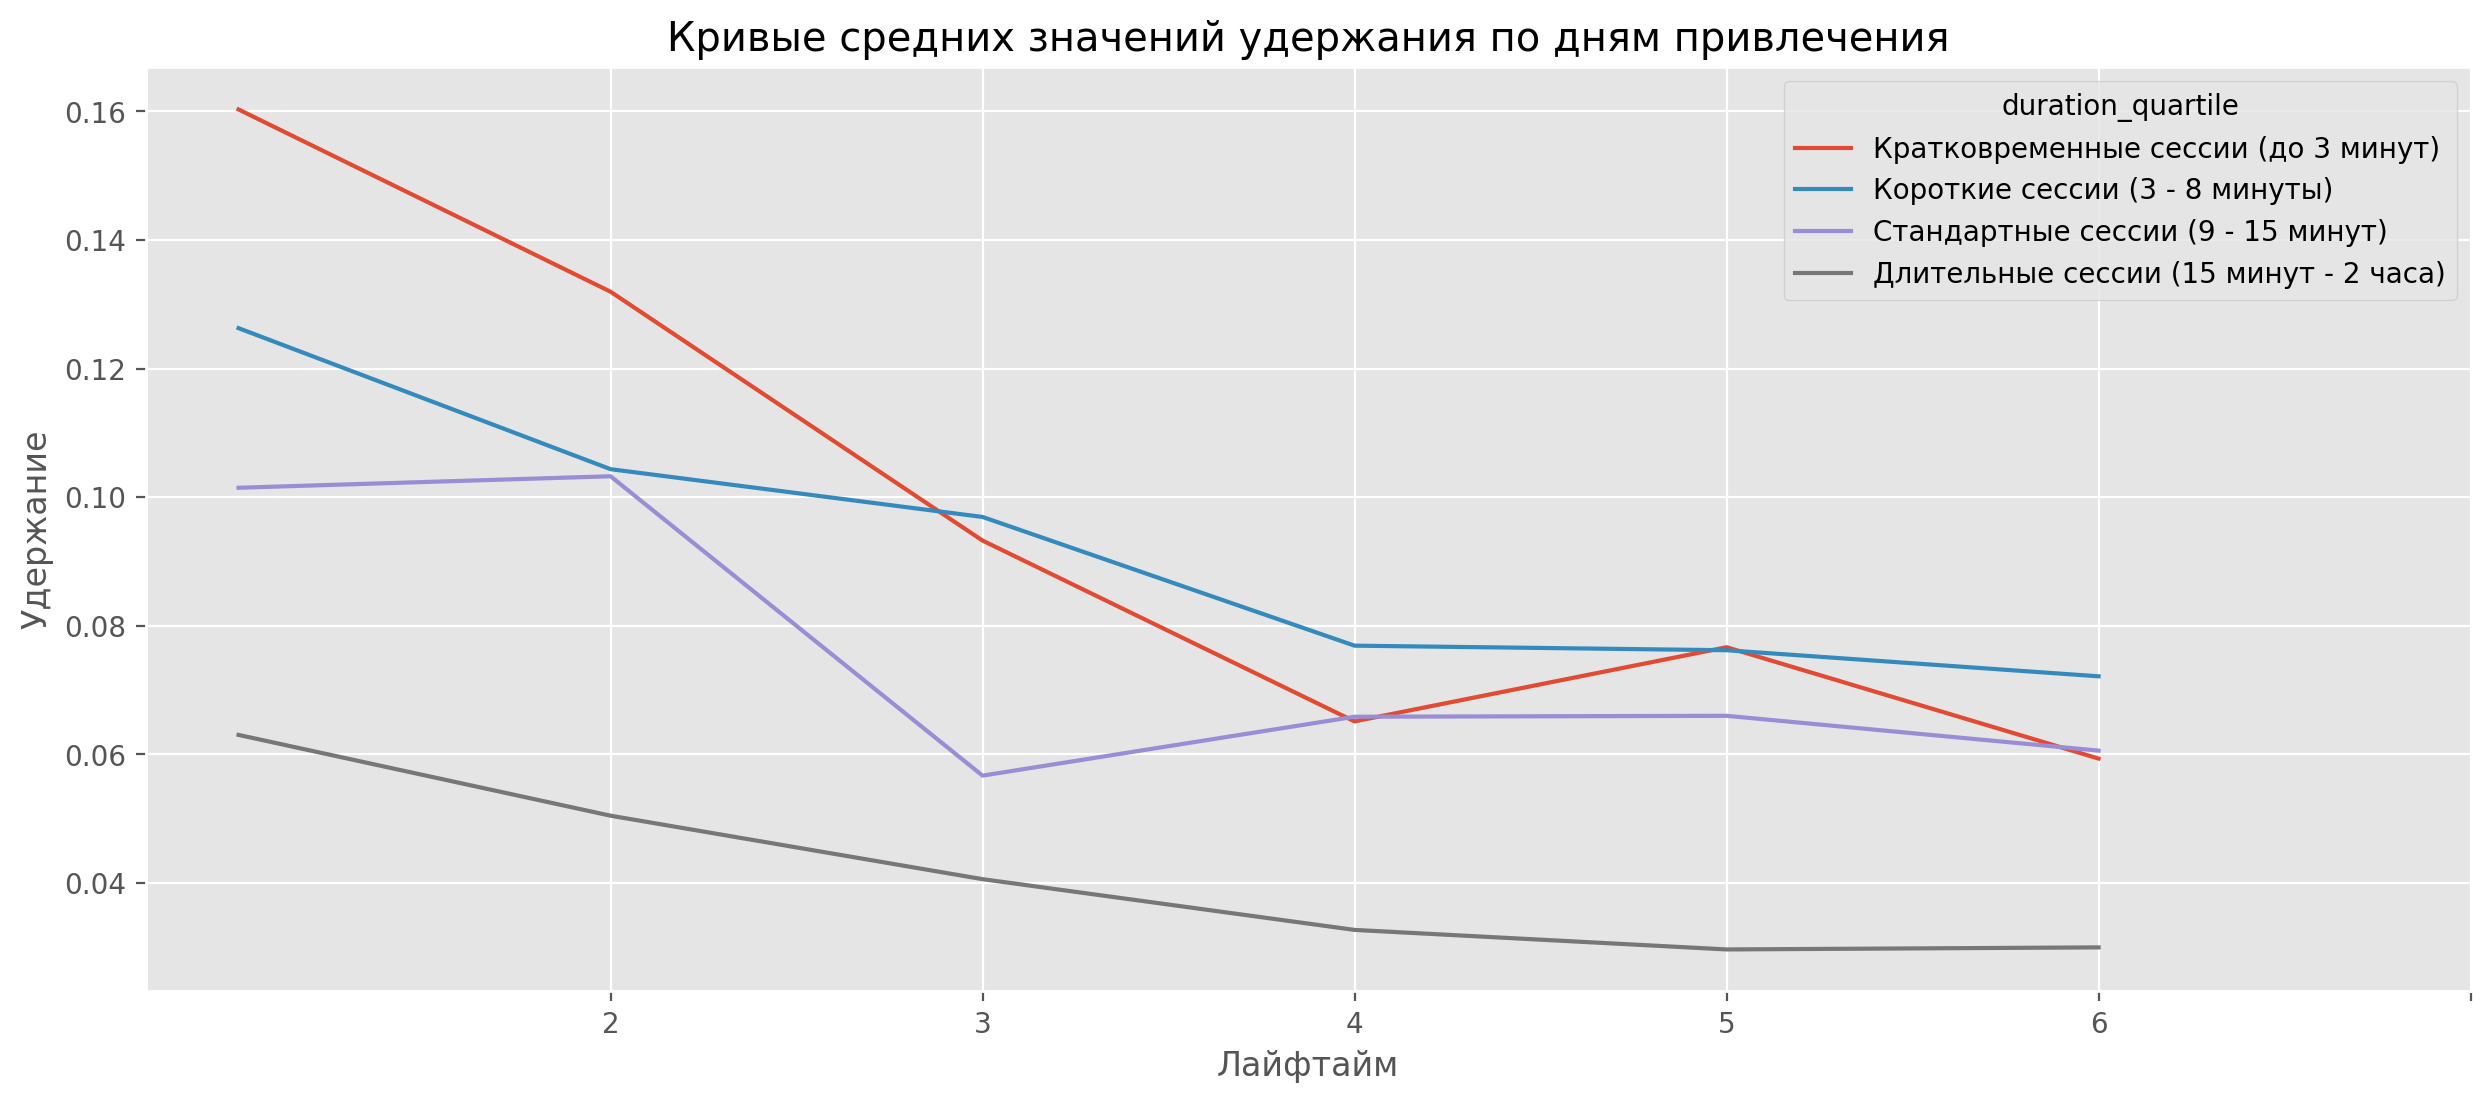

In [65]:
# строим кривые удержания

report = result_grouped.groupby('duration_quartile').mean().drop(columns = ['cohort_size', 0])

report.T.plot(
    grid=True,  # добавляем сетку
    xticks=list(report.columns.values))

plt.xlabel('Лайфтайм')
plt.ylabel('Удержание')
plt.title('Кривые средних значений удержания по дням привлечения')
plt.show()

Кривые удержания для средних значений лучше показывают, что пользователи с длительными сессиями имеют худшее удержание, среди всех групп, а пользователей с сессиями до 3 минут - лучшее.
К 7 дню разница в удержании между пользователями с сессиями от 3 минут до 15 практически не отличается.

#### Расчет конверсии для каждой группы.

Для расчета конверсии в каждой группе, создадим словарь с отдельными группами.

In [66]:
# добавим колонку 'duration_quartile' к датасету df
df_duration_quartile = pd.merge(df, profiles[['user_id', 'duration_quartile']], on='user_id', how='left')
df_duration_quartile.sample(5)

,event_time,event_name,user_id,source,session_id,session_start,session_end,duration_quartile
69045,2019-10-07 11:10:40.185470,map,ed13f6f0-08f4-4561-852e-456580f7a40d,yandex,1,2019-10-07 11:10:39.701908,2019-10-07 11:11:32.244407,Короткие сессии (3 - 8 минуты)
65597,2019-10-26 01:44:16.448294,advert_open,e13f9f32-7ae3-4204-8d60-898db040bcfc,yandex,18,2019-10-26 01:12:43.939116,2019-10-26 01:54:02.542245,Длительные сессии (15 минут - 2 часа)
54085,2019-10-25 21:33:00.849248,photos_show,be54d10b-9302-46be-b111-def7ac06ce31,yandex,1,2019-10-25 21:20:47.565383,2019-10-25 21:33:00.849248,Стандартные сессии (9 - 15 минут)
11804,2019-10-24 00:03:18.003933,photos_show,25069cad-0d00-48cb-a627-0871a877307e,google,5,2019-10-23 23:58:54.901923,2019-10-24 00:10:53.347255,Короткие сессии (3 - 8 минуты)
57122,2019-10-11 11:57:03.044107,search,c81944b3-3642-4c5d-8408-9e401263cc53,other,4,2019-10-11 11:57:03.044107,2019-10-11 12:03:59.954067,Кратковременные сессии (до 3 минут)


In [67]:
# Словарь с названиями переменных и соответствующими условиями
session_types = {
    'short_term_sessions': 'Кратковременные сессии (до 3 минут)',
    'short_sessions': 'Короткие сессии (3 - 8 минуты)',
    'standart_sessions': 'Стандартные сессии (9 - 15 минут)',
    'long_sessions': 'Длительные сессии (15 минут - 2 часа)'
}

filtered_sessions = {}

for session_name, quartile_value in session_types.items():
    filtered_sessions[session_name] = df_duration_quartile.query('duration_quartile == @quartile_value')
filtered_sessions['short_term_sessions'].head()

,event_time,event_name,user_id,source,session_id,session_start,session_end,duration_quartile
148,2019-10-25 16:44:41.263364,contacts_show,00551e79-152e-4441-9cf7-565d7eb04090,yandex,1,2019-10-25 16:44:41.263364,2019-10-25 16:44:44.786860,Кратковременные сессии (до 3 минут)
149,2019-10-25 16:44:44.786860,contacts_call,00551e79-152e-4441-9cf7-565d7eb04090,yandex,1,2019-10-25 16:44:41.263364,2019-10-25 16:44:44.786860,Кратковременные сессии (до 3 минут)
150,2019-10-28 13:08:15.809056,search,00551e79-152e-4441-9cf7-565d7eb04090,yandex,2,2019-10-28 13:08:15.809056,2019-10-28 13:17:31.950103,Кратковременные сессии (до 3 минут)
151,2019-10-28 13:10:40.331441,contacts_show,00551e79-152e-4441-9cf7-565d7eb04090,yandex,2,2019-10-28 13:08:15.809056,2019-10-28 13:17:31.950103,Кратковременные сессии (до 3 минут)
152,2019-10-28 13:10:49.415326,contacts_call,00551e79-152e-4441-9cf7-565d7eb04090,yandex,2,2019-10-28 13:08:15.809056,2019-10-28 13:17:31.950103,Кратковременные сессии (до 3 минут)


Построим воронки соответствующих групп с помощью функции calculate_funnel() и функции построения воронки, что были написаны выше.
Так как нужно построить 8 разных воронок:

In [68]:
# вызываем функцию построения воронки для всех групп

for funnel, funnel_way in zip(funnels, funnels_way):
    funnel_data = {
            'short_term_sessions': {
                'title': 'Кратковременные сессии (до 3 минут)',
                'color': '#1f77b4',
                'stages': funnel
            },
            'short_sessions': {
                'title': 'Короткие сессии (3 - 8 минуты)',
                'color': '#ff7f0e',
                'stages': funnel
            },
            'standart_sessions': {
                'title': 'Стандартные сессии (9 - 15 минут)',
                'color': '#2ca02c',
                'stages': funnel
            },
            'long_sessions': {
                'title': 'Длительные сессии (15 минут - 2 часа)',
                'color': '#d62728',
                'stages': funnel
            }
            }

    funnel_building(funnel_data, filtered_sessions, funnel_way)


Пользователи воронки номер 1 (search -> advert_open -> photos_show -> contacts_show) из всех групп достигают целевое действие. Наибольшее количество пользователей, что достигают цели показала группа с длительностью сессий в 9-15 минут - 2.9% (12 человек) от общего числа пользователей в начале пути. Наименьшее количество - в кратковременных сессиях (до 3 минут) - 3 человек (0.7% от изначального). Интересно заметить, что на второй шаг меньше всего переходят пользователи из группы кратковременных сессий - всего 12% от изначального.

Воронка номер 2 (search -> tips_show -> tips_click -> photos_show -> contacts_show) демонстрирует меньшее количество дошедших до целевого действия. Здесь только две группы пользователей смогли продемонстрировать законченную воронку. 2 пользователя дошли до цели в группе "длительные сессии" и 1 в группе "короткие сессии". Две другие группы - "кратковременные сессии" и "стандартные сессии" не достигли цели. Важно отметить, что на второй шаг в воронке - tips_show - переходят довольно много людей, то есть рекомендации видят много, но кликают на них (tips_click) уже очень мало людей. Поэтому нужно задуматься над изменением рекомендаций или целесообразности их выдачи.

Расчет конверсии по группам

In [69]:
# подсчет конверсий для групп
data = {}
for session_name, quartile_value in session_types.items():

    cr = round((filtered_sessions[session_name]
          .query('event_name == "contacts_show"')['user_id'].nunique() /
          filtered_sessions[session_name]['user_id'].nunique() * 100), 3)
    data[quartile_value] = cr
    print(f'Конверсия группы {quartile_value} равна: {cr:.2f}%')

Конверсия группы Кратковременные сессии (до 3 минут) равна: 22.01%
Конверсия группы Короткие сессии (3 - 8 минуты) равна: 23.79%
Конверсия группы Стандартные сессии (9 - 15 минут) равна: 24.28%
Конверсия группы Длительные сессии (15 минут - 2 часа) равна: 21.34%


In [70]:
# конвертируем словарь в датафрейм
cr_df = pd.DataFrame(data.items(), columns=['session_name', 'conversion'])

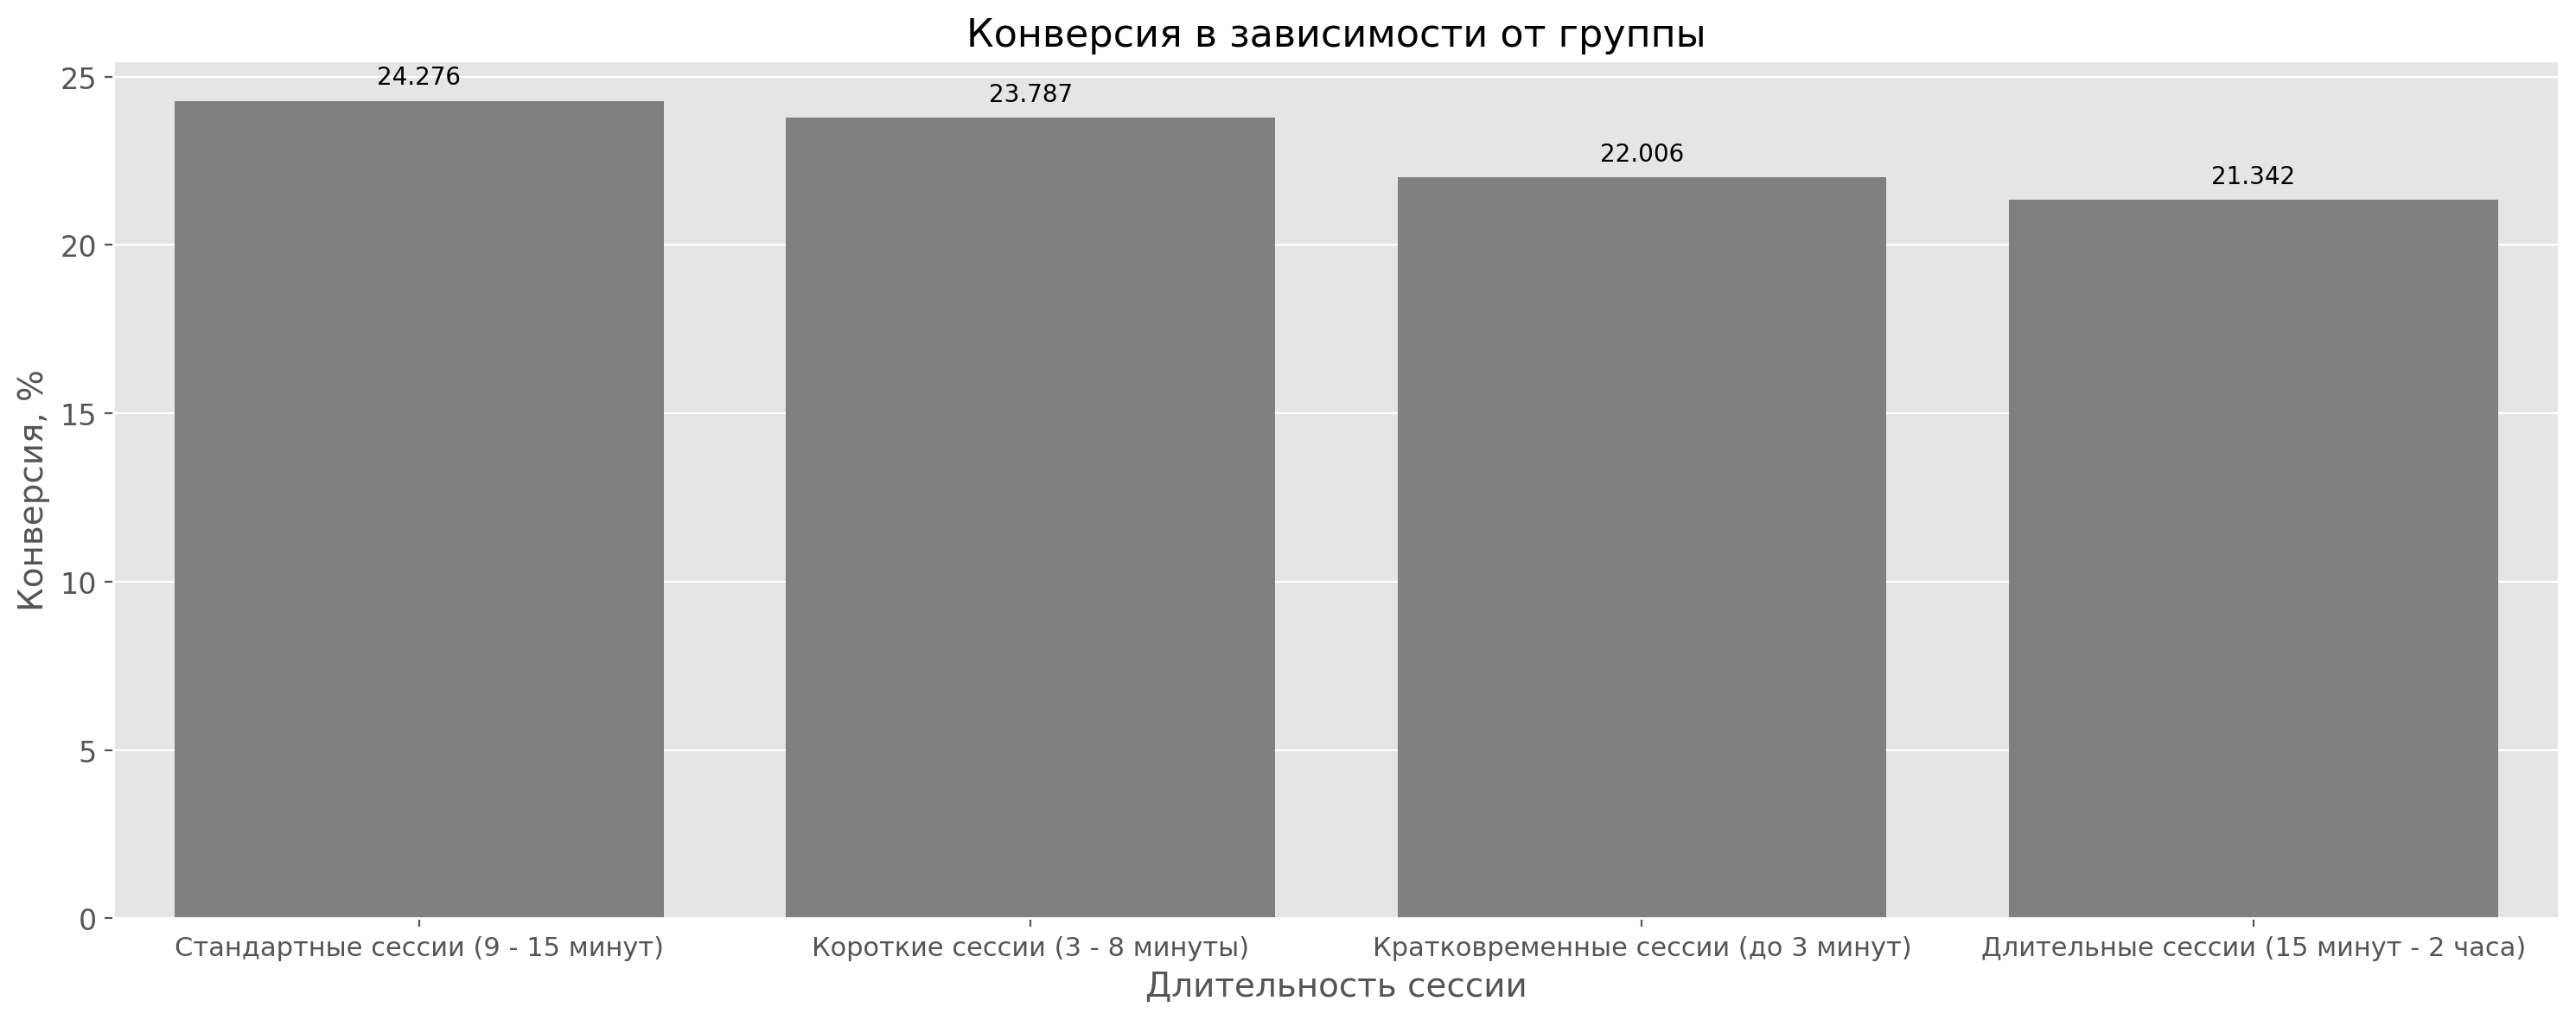

In [71]:
# строим график зависимости конверсий от длительности сессий
cr_df = cr_df.sort_values(by='conversion', ascending=False)

ax = sns.barplot(data=cr_df,
            x='session_name',
            y='conversion',
            color='gray')

plt.title('Конверсия в зависимости от группы', fontsize=16)
plt.xlabel('Длительность сессии', fontsize=14)
plt.ylabel('Конверсия, %', fontsize=14)

plt.xticks(fontsize=11)
plt.yticks(fontsize=12)

for index, value in enumerate(cr_df['conversion']):
    plt.text(index, value+0.5, str(value), ha='center', fontsize=10)

    plt.tight_layout()
plt.show()

Итого, наибольшая конверсия наблюдается в в группе "стандартные сессии (9-15 минут)" - 24.28%. Начальное предположение, что длительные сессии имеют больше конверсию, чем самые короткие не подтвердилось.

*Вывод по разделу:*
1. Сегментация по длительности сессий:

Пользователи разделены на 4 группы с примерно равным распределением (1071-1077 пользователей в каждой):

Кратковременные (до 3 мин): Лучшее удержание на 1-й день (до 30%), но низкая конверсия в воронках (0.7%).

Короткие (3-8 мин): Пиковое удержание у когорты 2019-10-10 (рост до 24.49%), умеренная конверсия.

Стандартные (9-15 мин): Наибольшая конверсия в воронке 1 (2.9%), наибольшая общая конверсия - 24.28%, стабильное удержание.

Длительные (15 мин – 2 ч): Худшее удержание среди всех групп, но редкие случаи завершения воронки 2.

2. Взаимосвязь длительности сессий и удержания:

Несмотря на высокую вовлеченность (сессии до 2 часов), удержание у этой группы ниже, чем у остальных.

Кратковременные сессии: Лидеры по удержанию на старте, но 12% конверсия на втором шаге воронки 1 (возможно, поверхностное взаимодействие).

3. Проблемы с рекомендациями (tips):

В воронке 2 кликают на рекомендации только 2 пользователя (из всех групп), несмотря на высокий охват (tips_show).

Рекомендации не приводят к целевым действиям, требуют пересмотра контента или алгоритмов.

4. Конверсия:

Наилучшая конверсия у группы с длиной сессий 9-15 минут - 24.28%.

## Проверить гипотезы

### Две группы (пользователи пришли по ссылкам из yandex и google) демонстрируют разную конверсию в просмотры контактов.

Сформулируем гипотезы:

Н0: Конверсия группы пользователей, пришедших по ссылкам из yandex не отличается от конверсии группы пользователей, пришедших по ссылкам из google.

H1: Конверсия групп пользователей из yandex и google разная.

In [72]:
# Словарь с названиями переменных и соответствующими условиями
source_types = {
    'users_google': 'google',
    'users_yandex': 'yandex'
    }

filtered_users = {}

for users_source, source in source_types.items():
    filtered_users[users_source] = df.query('source == @source')

users_google = filtered_users['users_google']['user_id'].nunique()
users_yandex = filtered_users['users_yandex']['user_id'].nunique()

In [73]:
# отфильтруем тех, кто соврешил целевое действие
cr_google = filtered_users['users_google'].query('event_name == "contacts_show"')['user_id'].nunique()

cr_yandex = filtered_users['users_yandex'].query('event_name == "contacts_show"')['user_id'].nunique()

In [74]:
# проверка гипотезы методом z-теста

# конверсии
conversions = [cr_yandex, cr_google]
# пользователи
samples = [users_yandex, users_google]

count = np.array(conversions)
nobs = np.array(samples)
z_stat, p_value_z = proportions_ztest(count, nobs, alternative='two-sided')

alpha = 0.05
p_value = p_value_z

display(f'Значение p_value: {p_value:.3f}')

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: конверсия разная')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

'Значение p_value: 0.824'

Не получилось отвергнуть нулевую гипотезу


Проверка гипотезы показала, что нулевую гипотезу не отвергаем. Конверсии двух групп пользователей, пришедших из yandex и google, не имеют статистически значимых различий.

### Между группами пользователей с наименьшей и наибольшей длительностями сессий наблюдается статистически значимая разница по конверсии в целевое действие.

Сформулируем гипотезы:

Н0: Конверсии групп пользователей, c наименьшей и наибольшей длительностями сессий, статистически не различаются.

H1: Конверсии групп пользователей, c наименьшей и наибольшей длительностями сессий, различны.

In [75]:
# группа с длительными сессиями
long_session= df_duration_quartile.query('duration_quartile == "Длительные сессии (15 минут - 2 часа)"')
long_session_users = long_session['user_id'].nunique()
long_session_users_cr = long_session.query('event_name == "contacts_show"')['user_id'].nunique()

In [76]:
# группа с кратковременными сессиями
short_term_session = df_duration_quartile.query('duration_quartile == "Кратковременные сессии (до 3 минут)"')
short_term_users = short_term_session['user_id'].nunique()
short_term_users_cr = short_term_session.query('event_name == "contacts_show"')['user_id'].nunique()

Проведем z-тест, аналогичный тому, что делали выше.

In [77]:
# проверка гипотезы методом z-теста

# конверсии
conversions = [short_term_users_cr, long_session_users_cr]
# пользователи
samples = [short_term_users, long_session_users]

count = np.array(conversions)
nobs = np.array(samples)
z_stat, p_value_z = proportions_ztest(count, nobs, alternative='two-sided')

alpha = 0.05
p_value = p_value_z

display(f'Значение p_value: {p_value:.3f}')

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: конверсия разная')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

'Значение p_value: 0.709'

Не получилось отвергнуть нулевую гипотезу


Здесь также не удалось опровергнуть нулевую гипотезу, что означает, что длительность сессий не влияет на конверсию.

*Вывод по гипотезам:*
1. Нулевую гипотезу о разности конверсии пользователей, привлеченных из yandex и google, не удалось опровергнуть. Статистические различия не были обнаружены.
2. Конверсия двух групп (Длительные сессии и Кратковременные сессии) статистически не различаются.

## Выводы и рекомендации для компании.

Общий вывод:


**Удержание пользователей:**

- Низкое (9-16% на 2-й день), с критическим падением к 7-му дню (нулевое у некоторых когорт).

- Лучшая когорта: 2019-10-08 (16.17%), худшие: 2019-10-09 и 2019-10-22.

**Активность и сессии:**

- 25% сессий короче 4 секунд.

- Средняя длительность сессии — 566 сек.

- 266 пользователей с аномально высокой активностью (>50 действий).

**Воронки и конверсия:**

- Общая конверсия в целевое действие без учета воронка составляет 22.85%.

- Конверсия в целевое действие в соответствие с воронкой: 1.5% (без рекомендаций), 0.18% (с рекомендациями).

- Рекомендации неэффективны: клики не приводят к конверсии.

**Сегментация:**

- Кратковременные сессии (до 3 мин): Высокое удержание (до 30%).

- Длительные сессии (>15 мин): Низкое удержание, редкие завершения воронок.

- Стандартные сессии(9-15 минут: Самая высокая общая конверсия - 24.28%.

- Парадокс: длительные сессии не коррелируют с удержанием и конверсией.

**Гипотезы:**

- Нет значимых различий в конверсии между источниками (Yandex/Google) и группами сессий.

**Рекомендации:**

- Провести аудит логгирования для исключения ошибок и анализа аномалий (боты/сверхактивные пользователи).

- Оптимизировать этап после взаимодействия с рекомендациями для повышения конверсии.

- Исследовать причины низкого удержания в проблемных когортах (2019-10-09, 2019-10-22).

- Пересмотреть алгоритмы и контент рекомендаций для повышения их эффективности.

- Углубиться в анализ поведения пользователей с длительными сессиями для улучшения их удержания и конверсии.